Loading dataset...
Dataset loaded: 2708 nodes, 10556 edges
Feature dimension: 1433, Number of classes: 7
--- Initial Geometric Analysis ---

--- Curvature Statistics: Original Input Graph ---
Mean: -8.5360
Median: -3.5000
Standard Deviation: 15.1431
Skewness: -2.9726
Min: -85.0000, Max: 6.0000
Number of edges: 3000
Negative curvature edges: 2367 (78.9%)
------------------------------------

CHOOSE EXPERIMENT TYPE:
1. Hyperparameter Search
2. Statistical Robustness Analysis
3. Both (Recommended)

STEP 1: HYPERPARAMETER SEARCH

Alpha values: [0.001, 0.005, 0.01, 0.05, 0.1]
Learning rates: [0.0005, 0.001, 0.002, 0.005]
Runs per config: 5
Total experiments: 200

--- Config 1/20: α=0.001, lr=0.0005 ---
  Curv GAE: 0.6472 ± 0.0247
  Std GAE:  0.5660 ± 0.0327
  Improvement: +0.0812

--- Config 2/20: α=0.001, lr=0.001 ---
  Curv GAE: 0.6820 ± 0.0191
  Std GAE:  0.6172 ± 0.0111
  Improvement: +0.0648

--- Config 3/20: α=0.001, lr=0.002 ---
  Curv GAE: 0.7008 ± 0.0199
  Std GAE:  0.6864 ± 0.0234

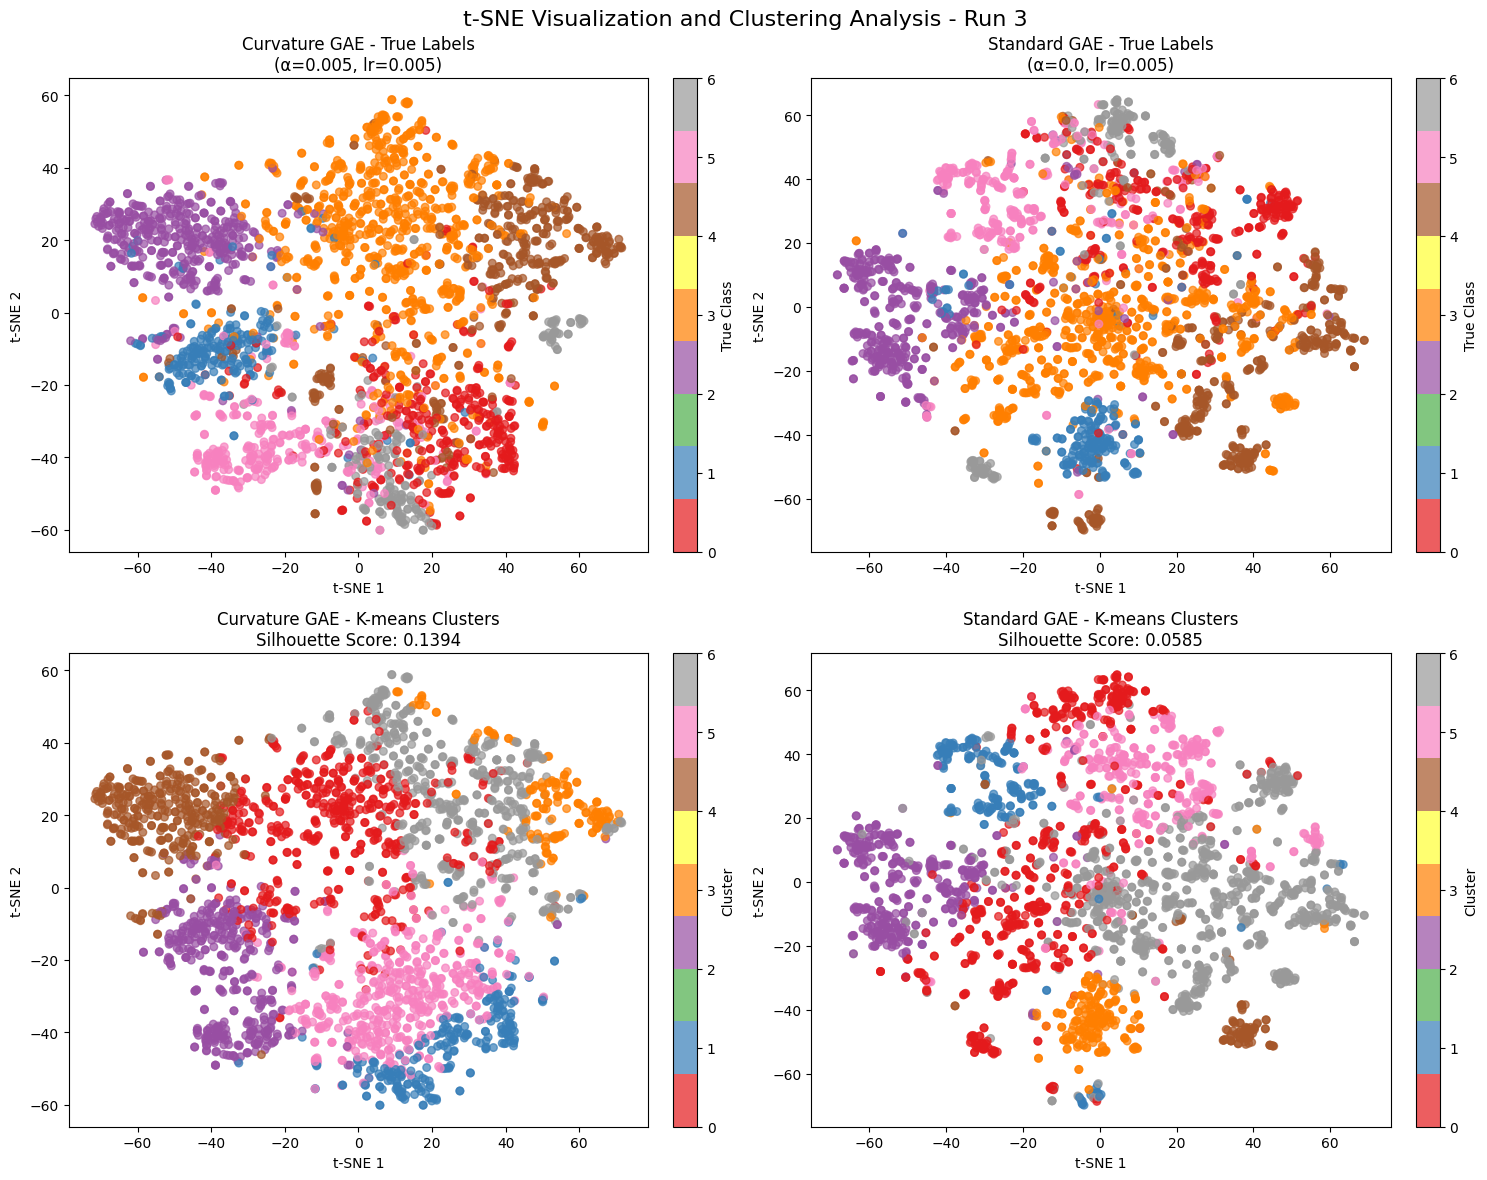


Additional Clustering Metrics:
Adjusted Rand Index:
  Curvature GAE: 0.2819
  Standard GAE: 0.2761
  ARI Improvement: +0.0058
Normalized Mutual Information:
  Curvature GAE: 0.3849
  Standard GAE: 0.4016
  NMI Improvement: -0.0167

t-SNE AND CLUSTERING SUMMARY
Silhouette Score Improvement: +0.0809
ARI Improvement: +0.0058
NMI Improvement: -0.0167


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import pandas as pd
from collections import defaultdict
# Add these additional imports at the top with your existing imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# PyTorch Geometric for GCN and datasets
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.nn import GCNConv

# Scikit-learn for evaluation and visualization
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def set_seed(seed):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# ------------------------------
# 1. Improved Differentiable Forman-Ricci Curvature
# ------------------------------

def compute_edge_curvature_batch(edge_index, adj_matrix, batch_size=1000):
    """
    Memory-efficient computation of differentiable Forman-Ricci curvature.
    Returns negative curvature values to encourage minimization.
    """
    device = adj_matrix.device
    n = adj_matrix.size(0)

    # Compute degrees once
    degrees = torch.sum(adj_matrix, dim=1)  # Shape: (n,)

    # Get actual edges from edge_index
    edges = edge_index.t()  # Shape: (num_edges, 2)
    num_edges = edges.size(0)

    curvatures = []

    # Process edges in batches
    for i in range(0, num_edges, batch_size):
        batch_end = min(i + batch_size, num_edges)
        batch_edges = edges[i:batch_end]  # Shape: (batch_size, 2)

        # Get source and target nodes
        src_nodes = batch_edges[:, 0]  # Shape: (batch_size,)
        tgt_nodes = batch_edges[:, 1]  # Shape: (batch_size,)

        # Get degrees for this batch
        deg_src = degrees[src_nodes]  # Shape: (batch_size,)
        deg_tgt = degrees[tgt_nodes]  # Shape: (batch_size,)

        # Compute common neighbors efficiently
        # For each edge (i,j), common neighbors = sum_k (A[i,k] * A[j,k])
        src_neighbors = adj_matrix[src_nodes]  # Shape: (batch_size, n)
        tgt_neighbors = adj_matrix[tgt_nodes]  # Shape: (batch_size, n)
        common_neighbors = torch.sum(src_neighbors * tgt_neighbors, dim=1)  # Shape: (batch_size,)

        # Forman-Ricci curvature formula: curv = 4 - deg_i - deg_j + 3 * common_neighbors
        batch_curvatures = 4 - deg_src - deg_tgt + 3 * common_neighbors
        curvatures.append(batch_curvatures)

    return torch.cat(curvatures, dim=0)

def adaptive_curvature_loss(edge_index, adj_matrix, target_stats=None, loss_type='minimize'):
    """
    Flexible curvature loss that can minimize, maximize, or match target distribution.

    Args:
        edge_index: Graph edges
        adj_matrix: Adjacency matrix (can be large - we'll sample)
        target_stats: (mean, std) of target curvature distribution
        loss_type: 'minimize', 'maximize', 'match_target', or 'adaptive'
    """
    device = adj_matrix.device
    dtype = adj_matrix.dtype

    # For very large graphs, sample edges to make computation tractable
    if adj_matrix.size(0) > 5000:
        # Sample a subset of edges for curvature computation
        num_edges = edge_index.size(1)
        max_edges = min(2000, num_edges)  # Limit to 2000 edges
        edge_indices = torch.randperm(num_edges, device=device)[:max_edges]
        sampled_edge_index = edge_index[:, edge_indices]
    else:
        sampled_edge_index = edge_index

    # Compute curvature for sampled edges
    edge_curvatures = compute_edge_curvature_batch(sampled_edge_index, adj_matrix, batch_size=500)

    if len(edge_curvatures) == 0:
        return torch.tensor(0.0, device=device, dtype=dtype)

    mean_curvature = torch.mean(edge_curvatures)
    std_curvature = torch.std(edge_curvatures)

    if loss_type == 'minimize':
        # Minimize mean curvature (encourage negative values)
        target_mean = target_stats[0] if target_stats else -2.0
        loss = F.mse_loss(mean_curvature, torch.tensor(target_mean, device=device, dtype=dtype))

    elif loss_type == 'maximize':
        # Maximize mean curvature (encourage positive values)
        target_mean = target_stats[0] if target_stats else 2.0
        loss = F.mse_loss(mean_curvature, torch.tensor(target_mean, device=device, dtype=dtype))

    elif loss_type == 'match_target':
        # Match target curvature statistics
        if target_stats is None:
            return torch.tensor(0.0, device=device, dtype=dtype)

        target_mean, target_std = target_stats
        mean_loss = F.mse_loss(mean_curvature, torch.tensor(target_mean, device=device, dtype=dtype))
        std_loss = F.mse_loss(std_curvature, torch.tensor(target_std, device=device, dtype=dtype))
        loss = mean_loss + 0.5 * std_loss

    elif loss_type == 'adaptive':
        # Let the model learn optimal curvature distribution
        # Encourage diversity in curvature values (avoid collapse)
        variance_loss = torch.exp(-std_curvature)  # Penalize low variance

        # Soft constraint to keep curvatures in reasonable range
        range_penalty = F.relu(torch.abs(mean_curvature) - 10.0)  # Penalize extreme means

        loss = variance_loss + 0.1 * range_penalty

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

    return loss

# ------------------------------
# 2. Traditional Forman-Ricci Curvature for Reference
# ------------------------------

def compute_forman_ricci(G):
    """Returns a dictionary with Forman-Ricci curvature for each edge."""
    curvatures = {}
    for u, v in G.edges():
        if u == v: continue
        degree_u = G.degree[u]
        degree_v = G.degree[v]
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        curv = 4 - degree_u - degree_v + 3 * common_neighbors
        curvatures[(u, v)] = curv
    return curvatures

# ------------------------------
# 3. Improved GCN Model with Better Architecture
# ------------------------------

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels))

        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        # Final layer without activation
        x = self.convs[-1](x, edge_index)
        return x

class GraphAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_channels, out_channels, num_layers)

        # Improved decoder with multiple layers
        self.decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels, in_channels)
        )

    def forward(self, data, compute_adj=True):
        x, edge_index = data.x, data.edge_index
        z = self.encoder(x, edge_index)
        recon_features = self.decoder(z)

        recon_adj = None
        if compute_adj:
            # Always try to compute adjacency, but use efficient methods for large graphs
            z_normalized = F.normalize(z, p=2, dim=1)

            if z.size(0) <= 4000:
                # For smaller graphs: full dense reconstruction
                recon_adj = torch.mm(z_normalized, z_normalized.t())
                recon_adj = torch.sigmoid(recon_adj)
                # Zero out diagonal (no self-loops)
                recon_adj = recon_adj * (1 - torch.eye(z.size(0), device=z.device))
            else:
                # For larger graphs: sparse reconstruction using existing edges
                src, tgt = edge_index
                edge_weights = torch.sum(z_normalized[src] * z_normalized[tgt], dim=1)
                edge_weights = torch.sigmoid(edge_weights)

                # Create sparse adjacency representation and convert to dense
                # This is still memory efficient as we only compute for existing edges
                recon_adj = torch.zeros(z.size(0), z.size(0), device=z.device, dtype=z.dtype)
                recon_adj[src, tgt] = edge_weights
                recon_adj[tgt, src] = edge_weights  # Make symmetric

        return recon_features, z, recon_adj

# ------------------------------
# 4. Improved Training Function
# ------------------------------

def train(model, data, target_curvature_stats, optimizer, epochs,
          lambda_struct=0.1, alpha_curv=0.01, curvature_loss_type='match_target',
          verbose=True):
    """
    Training function for graph denoising task.

    The model receives noisy features and tries to reconstruct clean features and structure.

    Args:
        curvature_loss_type: 'minimize', 'maximize', 'match_target', or 'adaptive'
    """
    model.train()

    # Ensure data is in float32
    data.x = data.x.float()

    # DENOISING TASK: Targets are the clean original data
    clean_features = clean_data_features
    clean_adj = to_dense_adj(clean_data_edge_index).squeeze(0).float()
    clean_adj = clean_adj * (1 - torch.eye(data.x.size(0), device=data.x.device))

    # Handle large graphs efficiently
    use_full_adj = data.x.size(0) <= 4000

    if verbose:
        print(f"\n--- Training Graph Denoising Model ---")
        print(f"λ_struct={lambda_struct}, α_curv={alpha_curv}")
        print(f"Graph size: {data.x.size(0)} nodes, {data.edge_index.size(1)} edges")
        print(f"Using full adjacency: {use_full_adj}, Curvature loss type: {curvature_loss_type}")
        print(f"Task: Reconstruct CLEAN graph from NOISY input")

        # Show denoising challenge
        feature_mse = F.mse_loss(data.x, clean_features).item()
        print(f"Initial feature MSE (noisy vs clean): {feature_mse:.4f}")

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20)

    # Track losses for consistent reporting
    losses = {'total': [], 'feature': [], 'structure': [], 'curvature': []}

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass - always try to compute adjacency for curvature
        recon_features, z, recon_adj = model(data, compute_adj=True)

        # Loss 1: Feature Denoising Loss
        feature_loss = F.mse_loss(recon_features, clean_features)

        # Loss 2: Structure Reconstruction Loss (reconstruct clean adjacency)
        structure_loss = torch.tensor(0.0, dtype=data.x.dtype, device=data.x.device)
        if use_full_adj and recon_adj is not None:
            structure_loss = F.binary_cross_entropy(recon_adj, clean_adj)

        # Loss 3: Curvature Regularization (encourage clean curvature properties)
        curvature_loss = torch.tensor(0.0, dtype=data.x.dtype, device=data.x.device)
        if alpha_curv > 0 and recon_adj is not None:
            # Apply curvature regularization to the reconstructed adjacency
            # Target: original clean graph's curvature statistics
            curvature_loss = adaptive_curvature_loss(
                clean_data_edge_index, recon_adj, target_curvature_stats, curvature_loss_type
            )

        # Add L2 regularization
        l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
        total_loss = feature_loss + (lambda_struct * structure_loss) + (alpha_curv * curvature_loss) + 1e-5 * l2_reg

        total_loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(total_loss)

        # Store losses for analysis
        losses['total'].append(total_loss.item())
        losses['feature'].append(feature_loss.item())
        losses['structure'].append(structure_loss.item())
        losses['curvature'].append(curvature_loss.item())

        if verbose and epoch % 25 == 0:
            print(f"Epoch {epoch:03d}, Loss: {total_loss.item():.4f}, "
                  f"Feat: {feature_loss.item():.4f}, Struct: {structure_loss.item():.4f}, "
                  f"Curv: {curvature_loss.item():.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Clear cache periodically
        if epoch % 100 == 0:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return model

# ------------------------------
# 5. Enhanced Analysis Functions
# ------------------------------

def analyze_reconstructed_curvature(model, data, title="Reconstructed Graph", max_edges=2000):
    """Enhanced analysis of reconstructed curvature."""
    model.eval()
    with torch.no_grad():
        _, z, recon_adj = model(data, compute_adj=True)

        if recon_adj is None:
            print(f"Skipping curvature analysis for {title} (graph too large)")
            return {}, None

        # Convert to NetworkX with edge limit
        adj_np = recon_adj.cpu().numpy()
        adj_binary = (adj_np > 0.3).astype(int)  # Higher threshold for cleaner graph

        # Create NetworkX graph
        G_recon = nx.from_numpy_array(adj_binary)

        # Remove isolated nodes and limit edges
        G_recon.remove_nodes_from(list(nx.isolates(G_recon)))
        if G_recon.number_of_edges() > max_edges:
            # Keep edges with highest weights
            edges_with_weights = [(u, v, adj_np[u, v]) for u, v in G_recon.edges()]
            edges_with_weights.sort(key=lambda x: x[2], reverse=True)
            edges_to_keep = [(u, v) for u, v, w in edges_with_weights[:max_edges]]
            G_recon = nx.Graph()
            G_recon.add_edges_from(edges_to_keep)

        recon_curvature = compute_forman_ricci(G_recon)
        return recon_curvature, G_recon

def get_curvature_stats(curv_dict, title, verbose=True):
    """Enhanced curvature statistics."""
    if not curv_dict:
        if verbose:
            print(f"No curvature data for '{title}'.")
        return None, None

    values = np.array(list(curv_dict.values()))
    mean = np.mean(values)
    std = np.std(values)
    median = np.median(values)
    skewness = skew(values)
    min_val = np.min(values)
    max_val = np.max(values)

    if verbose:
        print(f"\n--- Curvature Statistics: {title} ---")
        print(f"Mean: {mean:.4f}")
        print(f"Median: {median:.4f}")
        print(f"Standard Deviation: {std:.4f}")
        print(f"Skewness: {skewness:.4f}")
        print(f"Min: {min_val:.4f}, Max: {max_val:.4f}")
        print(f"Number of edges: {len(values)}")
        print(f"Negative curvature edges: {np.sum(values < 0)} ({100*np.sum(values < 0)/len(values):.1f}%)")
        print("------------------------------------")

    return mean, std

def evaluate_node_classification_hyper(z, data):
    """Enhanced node classification evaluation."""
    X = z.detach().cpu().numpy()
    y = data.y.cpu().numpy()

    X_train = X[data.train_mask]
    y_train = y[data.train_mask]
    X_test = X[data.val_mask]
    y_test = y[data.val_mask]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Try different solvers and regularization
    best_acc = 0
    for C in [0.01, 0.1, 1.0, 10.0]:
        classifier = LogisticRegression(
            solver='lbfgs', max_iter=2000, random_state=42, C=C
        )
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > best_acc:
            best_acc = acc

    return best_acc

def final_evaluate_node_classification(z, data):
    """Enhanced node classification evaluation."""
    X = z.detach().cpu().numpy()
    y = data.y.cpu().numpy()

    X_train = X[data.train_mask]
    y_train = y[data.train_mask]
    X_test = X[data.test_mask]
    y_test = y[data.test_mask]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Try different solvers and regularization
    best_acc = 0
    for C in [0.01, 0.1, 1.0, 10.0]:
        classifier = LogisticRegression(
            solver='lbfgs', max_iter=2000, random_state=42, C=C
        )
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > best_acc:
            best_acc = acc

    return best_acc


# ------------------------------
# 6. Statistical Analysis Functions
# ------------------------------

def compute_statistics(values):
    """Compute comprehensive statistics for a list of values."""
    values = np.array(values)
    return {
        'mean': np.mean(values),
        'std': np.std(values),
        'median': np.median(values),
        'min': np.min(values),
        'max': np.max(values),
        'q25': np.percentile(values, 25),
        'q75': np.percentile(values, 75)
    }

def print_statistical_summary(results_dict, metric_name):
    """Print statistical summary for multiple runs."""
    print(f"\n=== Statistical Summary: {metric_name} ===")

    for model_type, values in results_dict.items():
        stats = compute_statistics(values)
        print(f"\n{model_type}:")
        print(f"  Mean ± Std: {stats['mean']:.4f} ± {stats['std']:.4f}")
        print(f"  Median [Q25, Q75]: {stats['median']:.4f} [{stats['q25']:.4f}, {stats['q75']:.4f}]")
        print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")

# ------------------------------
# 8. Hyperparameter Tuning Functions
# ------------------------------

def hyperparameter_search(data, target_stats, alpha_values, lr_values, num_runs_per_config=5):
    """
    Perform grid search over alpha_curv and learning rate.

    Args:
        data: Graph data
        target_stats: Target curvature statistics
        alpha_values: List of alpha_curv values to try
        lr_values: List of learning rates to try
        num_runs_per_config: Number of runs per hyperparameter configuration

    Returns:
        best_config, results_df
    """
    print(f"\n{'='*60}")
    print(f"Alpha values: {alpha_values}")
    print(f"Learning rates: {lr_values}")
    print(f"Runs per config: {num_runs_per_config}")
    print(f"Total experiments: {len(alpha_values) * len(lr_values) * num_runs_per_config * 2}")  # *2 for curv vs std
    print(f"{'='*60}")

    results = []
    config_id = 0

    for alpha_curv in alpha_values:
        for lr in lr_values:
            config_id += 1
            print(f"\n--- Config {config_id}/{len(alpha_values) * len(lr_values)}: α={alpha_curv}, lr={lr} ---")

            # Store results for this configuration
            config_results = {
                'alpha_curv': alpha_curv,
                'lr': lr,
                'curv_accuracies': [],
                'std_accuracies': [],
            }
            seed_values = [2,12,22,32,42,52,62,72,82,92]
            for run in range(num_runs_per_config):
                # Create fresh copy of data
                data_copy = data.clone()

                # Train curvature-regularized model
                set_seed(seed_values[run])  # Different seed for model initialization
                curv_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
                optimizer = torch.optim.Adam(curv_model.parameters(), lr=lr, weight_decay=1e-4)

                curv_model = train(
                    curv_model, data_copy, target_stats, optimizer,
                    epochs=150, lambda_struct=1.0, alpha_curv=alpha_curv,
                    curvature_loss_type='match_target', verbose=False
                )

                # Train standard model
                set_seed(seed_values[run])  # Same seed for fair comparison
                std_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
                optimizer_std = torch.optim.Adam(std_model.parameters(), lr=lr, weight_decay=1e-4)

                std_model = train(
                    std_model, data_copy, target_stats, optimizer_std,
                    epochs=150, lambda_struct=1.0, alpha_curv=0.0,
                    curvature_loss_type='adaptive', verbose=False
                )

                # Evaluate both models
                curv_model.eval()
                std_model.eval()

                with torch.no_grad():
                    _, z_curv, _ = curv_model(data_copy, compute_adj=False)
                    _, z_std, _ = std_model(data_copy, compute_adj=False)

                    # Node classification
                    acc_curv = evaluate_node_classification_hyper(z_curv, data_copy)
                    acc_std = evaluate_node_classification_hyper(z_std, data_copy)

                    config_results['curv_accuracies'].append(acc_curv)
                    config_results['std_accuracies'].append(acc_std)
                # Clean up
                del curv_model, std_model
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

            # Compute averages for this configuration
            config_summary = {
                'alpha_curv': alpha_curv,
                'lr': lr,
                'curv_mean_acc': np.mean(config_results['curv_accuracies']),
                'curv_std_acc': np.std(config_results['curv_accuracies']),
                'std_mean_acc': np.mean(config_results['std_accuracies']),
                'std_std_acc': np.std(config_results['std_accuracies']),
                'mean_acc_improvement': np.mean(config_results['curv_accuracies']) - np.mean(config_results['std_accuracies']),
                'std_acc_improvement': np.std(np.array(config_results['curv_accuracies']) - np.array(config_results['std_accuracies'])),
            }

            results.append(config_summary)
            print(f"  Curv GAE: {config_summary['curv_mean_acc']:.4f} ± {config_summary['curv_std_acc']:.4f}")
            print(f"  Std GAE:  {config_summary['std_mean_acc']:.4f} ± {config_summary['std_std_acc']:.4f}")
            print(f"  Improvement: {config_summary['mean_acc_improvement']:+.4f}")


    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)

    # Find best configuration based on accuracy improvement
    best_curv_idx = results_df['curv_mean_acc'].idxmax()
    best_curv_config = results_df.iloc[best_curv_idx]

    best_std_idx = results_df['std_mean_acc'].idxmax()
    best_std_config = results_df.iloc[best_std_idx]

    print(f"\n{'='*60}")
    print(f"INDEPENDENT HYPERPARAMETER SEARCH RESULTS")
    print(f"{'='*60}")
    
    print(f"\nBest configuration for CURVATURE-REGULARIZED GAE:")
    print(f"  Alpha: {best_curv_config['alpha_curv']}")
    print(f"  Learning rate: {best_curv_config['lr']}")
    print(f"  Validation accuracy: {best_curv_config['curv_mean_acc']:.4f} ± {best_curv_config['curv_std_acc']:.4f}")
    
    print(f"\nBest configuration for STANDARD GAE:")
    print(f"  Alpha: {best_std_config['alpha_curv']} (ignored)")
    print(f"  Learning rate: {best_std_config['lr']}")
    print(f"  Validation accuracy: {best_std_config['std_mean_acc']:.4f} ± {best_std_config['std_std_acc']:.4f}")

    # Show if they happen to use the same learning rate
    if best_curv_config['lr'] == best_std_config['lr']:
        print(f"\n📝 Note: Both models achieved best performance with lr={best_curv_config['lr']}")
        shared_lr = best_curv_config['lr']
    else:
        print(f"\n📝 Note: Models prefer different learning rates")
        print(f"   Curvature GAE: lr={best_curv_config['lr']}")
        print(f"   Standard GAE: lr={best_std_config['lr']}")
        shared_lr = None

    # Show top configurations for each model
    print(f"\nTop 3 configurations for Curvature-Regularized GAE:")
    top_curv = results_df.nlargest(3, 'curv_mean_acc')
    for i, (_, row) in enumerate(top_curv.iterrows()):
        print(f"  {i+1}. α={row['alpha_curv']}, lr={row['lr']}: {row['curv_mean_acc']:.4f}")

    print(f"\nTop 3 configurations for Standard GAE:")
    top_std = results_df.nlargest(3, 'std_mean_acc')
    for i, (_, row) in enumerate(top_std.iterrows()):
        print(f"  {i+1}. α={row['alpha_curv']}, lr={row['lr']}: {row['std_mean_acc']:.4f}")

    # Optional: Show performance when both use the same hyperparameters
    if shared_lr is not None:
        shared_config = results_df[results_df['lr'] == shared_lr]
        if len(shared_config) > 0:
            best_shared = shared_config.loc[shared_config['curv_mean_acc'].idxmax()]
            print(f"\nFair comparison using shared lr={shared_lr}, α={best_shared['alpha_curv']}:")
            print(f"  Curvature GAE: {best_shared['curv_mean_acc']:.4f} ± {best_shared['curv_std_acc']:.4f}")
            print(f"  Standard GAE:  {best_shared['std_mean_acc']:.4f} ± {best_shared['std_std_acc']:.4f}")
            print(f"  Improvement:   {best_shared['mean_acc_improvement']:+.4f}")

    return best_curv_config, best_std_config, results_df

def run_robustness_with_independent_hyperparams(data, target_stats, best_curv_config, best_std_config, 
                                               num_runs=10, noise_level=0.0):
    """
    Run robustness analysis using independently selected hyperparameters for each model.
    """
    print(f"\n{'='*60}")
    print(f"ROBUSTNESS ANALYSIS WITH INDEPENDENT HYPERPARAMETERS")
    print(f"Curvature GAE: α={best_curv_config['alpha_curv']}, lr={best_curv_config['lr']}")
    print(f"Standard GAE: α=0.0, lr={best_std_config['lr']}")
    print(f"Number of runs: {num_runs}")
    print(f"Noise level: {noise_level}")
    print(f"{'='*60}")

    # Storage for results across multiple runs
    all_results = {
        'curv_accuracy': [],
        'std_accuracy': [],
        'accuracy_improvement': []
    }
    seed_values = [2,12,22,32,42,52,62,72,82,92]
    # Run multiple experiments
    for run_id in range(num_runs):
        # Create fresh copy of data for each run
        data_copy = data.clone()
        
        # Add noise if specified
        if noise_level > 0:
            noise = torch.randn_like(data_copy.x) * noise_level
            data_copy.x = data_copy.x + noise

        # Train curvature-regularized model with its best hyperparameters
        set_seed(seed_values[run_id])
        curv_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
        optimizer_curv = torch.optim.Adam(
            curv_model.parameters(), 
            lr=best_curv_config['lr'], 
            weight_decay=1e-4
        )

        curv_model = train(
            curv_model, data_copy, target_stats, optimizer_curv,
            epochs=200, lambda_struct=1.0, alpha_curv=best_curv_config['alpha_curv'],
            curvature_loss_type='match_target', verbose=(run_id == 0)
        )

        # Train standard model with its best hyperparameters
        set_seed(seed_values[run_id])  # Same seed for model initialization
        std_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
        optimizer_std = torch.optim.Adam(
            std_model.parameters(), 
            lr=best_std_config['lr'], 
            weight_decay=1e-4
        )

        std_model = train(
            std_model, data_copy, target_stats, optimizer_std,
            epochs=200, lambda_struct=1.0, alpha_curv=0.0,
            curvature_loss_type='adaptive', verbose=False
        )

        # Evaluate both models
        curv_model.eval()
        std_model.eval()

        with torch.no_grad():
            _, z_curv, _ = curv_model(data_copy, compute_adj=False)
            _, z_std, _ = std_model(data_copy, compute_adj=False)

            # Final evaluation on test set
            acc_curv = final_evaluate_node_classification(z_curv, data_copy)
            acc_std = final_evaluate_node_classification(z_std, data_copy)

            all_results['curv_accuracy'].append(acc_curv)
            all_results['std_accuracy'].append(acc_std)
            all_results['accuracy_improvement'].append(acc_curv - acc_std)

        acc_improvement = acc_curv - acc_std
        print(f"Run {run_id + 1}/{num_runs} completed - Acc improvement: {acc_improvement:+.4f}")

        # Clean up memory
        del curv_model, std_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Statistical Analysis
    print(f"\n{'='*60}")
    print(f"STATISTICAL RESULTS (INDEPENDENT HYPERPARAMETERS)")
    print(f"{'='*60}")

    # Classification accuracy comparison
    accuracy_results = {
        'Curvature-Regularized GAE': all_results['curv_accuracy'],
        'Standard GAE': all_results['std_accuracy']
    }

    print_statistical_summary(accuracy_results, "Node Classification Accuracy")

    # Improvement analysis
    improvement_stats = compute_statistics(all_results['accuracy_improvement'])
    print(f"\n=== Classification Accuracy Improvement Analysis ===")
    print(f"Mean Improvement: {improvement_stats['mean']:.4f} ± {improvement_stats['std']:.4f}")
    print(f"Median [Q25, Q75]: {improvement_stats['median']:.4f} [{improvement_stats['q25']:.4f}, {improvement_stats['q75']:.4f}]")

    # Statistical significance test
    from scipy import stats
    if len(all_results['curv_accuracy']) > 1 and len(all_results['std_accuracy']) > 1:
        t_stat, p_value = stats.ttest_rel(all_results['curv_accuracy'], all_results['std_accuracy'])
        print(f"Paired t-test p-value: {p_value:.4f}")
        print(f"Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")

    # Final summary
    print(f"\n{'='*60}")
    print(f"FINAL SUMMARY")
    print(f"{'='*60}")
    print(f"Curvature GAE (α={best_curv_config['alpha_curv']}, lr={best_curv_config['lr']}): {np.mean(all_results['curv_accuracy']):.4f} ± {np.std(all_results['curv_accuracy']):.4f}")
    print(f"Standard GAE (α=0.0, lr={best_std_config['lr']}): {np.mean(all_results['std_accuracy']):.4f} ± {np.std(all_results['std_accuracy']):.4f}")
    print(f"Improvement: {improvement_stats['mean']:+.4f} ± {improvement_stats['std']:.4f}")

    if p_value < 0.05:
        print(f"\n✅ Results are statistically significant (p={p_value:.4f})")
    else:
        print(f"\n⚠️  Results are not statistically significant (p={p_value:.4f})")

    return all_results

# Add these functions after your existing functions (around line 600-700)

def find_closest_run_to_mean(all_results):
    """
    Find the run whose accuracy is closest to the mean accuracy.
    Returns the index of that run.
    """
    curv_accuracies = np.array(all_results['curv_accuracy'])
    std_accuracies = np.array(all_results['std_accuracy'])
    
    # Calculate mean accuracies
    mean_curv_acc = np.mean(curv_accuracies)
    mean_std_acc = np.mean(std_accuracies)
    
    # Find run closest to mean for curvature model
    curv_distances = np.abs(curv_accuracies - mean_curv_acc)
    closest_curv_run = np.argmin(curv_distances)
    
    # Find run closest to mean for standard model  
    std_distances = np.abs(std_accuracies - mean_std_acc)
    closest_std_run = np.argmin(std_distances)
    
    print(f"Run closest to mean accuracy:")
    print(f"  Curvature GAE: Run {closest_curv_run + 1} (acc: {curv_accuracies[closest_curv_run]:.4f}, mean: {mean_curv_acc:.4f})")
    print(f"  Standard GAE: Run {closest_std_run + 1} (acc: {std_accuracies[closest_std_run]:.4f}, mean: {mean_std_acc:.4f})")
    
    # For simplicity, use the curvature model's closest run for both
    return closest_curv_run

def run_tsne_analysis(data, target_stats, best_curv_config, best_std_config, run_index):
    """
    Run the specified run index and perform t-SNE analysis with clustering.
    """
    print(f"\n{'='*60}")
    print(f"t-SNE AND CLUSTERING ANALYSIS - RUN {run_index + 1}")
    print(f"{'='*60}")
    
    seed_values = [2,12,22,32,42,52,62,72,82,92]
    
    # Create fresh copy of data
    data_copy = data.clone()
    
    # Train curvature-regularized model
    print("Training Curvature-Regularized GAE...")
    set_seed(seed_values[run_index])
    curv_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
    optimizer_curv = torch.optim.Adam(
        curv_model.parameters(), 
        lr=best_curv_config['lr'], 
        weight_decay=1e-4
    )
    
    curv_model = train(
        curv_model, data_copy, target_stats, optimizer_curv,
        epochs=200, lambda_struct=1.0, alpha_curv=best_curv_config['alpha_curv'],
        curvature_loss_type='match_target', verbose=False
    )
    
    # Train standard model
    print("Training Standard GAE...")
    set_seed(seed_values[run_index])
    std_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
    optimizer_std = torch.optim.Adam(
        std_model.parameters(), 
        lr=best_std_config['lr'], 
        weight_decay=1e-4
    )
    
    std_model = train(
        std_model, data_copy, target_stats, optimizer_std,
        epochs=200, lambda_struct=1.0, alpha_curv=0.0,
        curvature_loss_type='adaptive', verbose=False
    )
    
    # Get embeddings
    curv_model.eval()
    std_model.eval()
    
    with torch.no_grad():
        _, z_curv, _ = curv_model(data_copy, compute_adj=False)
        _, z_std, _ = std_model(data_copy, compute_adj=False)
    
    # Convert to numpy
    z_curv_np = z_curv.cpu().numpy()
    z_std_np = z_std.cpu().numpy()
    labels = data_copy.y.cpu().numpy()
    
    # Perform t-SNE
    print("Computing t-SNE embeddings...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    
    # t-SNE for curvature model
    tsne_curv = tsne.fit_transform(z_curv_np)
    
    # t-SNE for standard model (refit to avoid potential issues)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    tsne_std = tsne.fit_transform(z_std_np)
    
    # Clustering analysis
    print("Performing clustering analysis...")
    n_clusters = len(np.unique(labels))  # Use true number of classes
    
    # K-means clustering
    kmeans_curv = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_std = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    cluster_labels_curv = kmeans_curv.fit_predict(z_curv_np)
    cluster_labels_std = kmeans_std.fit_predict(z_std_np)
    
    # Silhouette scores
    sil_curv = silhouette_score(z_curv_np, cluster_labels_curv)
    sil_std = silhouette_score(z_std_np, cluster_labels_std)
    
    print(f"\nClustering Results:")
    print(f"  Curvature GAE Silhouette Score: {sil_curv:.4f}")
    print(f"  Standard GAE Silhouette Score: {sil_std:.4f}")
    print(f"  Silhouette Improvement: {sil_curv - sil_std:+.4f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f't-SNE Visualization and Clustering Analysis - Run {run_index + 1}', fontsize=16)
    
    # Define colors for classes
    n_classes = len(np.unique(labels))
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    # Plot 1: Curvature GAE - True Labels
    scatter1 = axes[0, 0].scatter(tsne_curv[:, 0], tsne_curv[:, 1], c=labels, cmap='Set1', alpha=0.7, s=30)
    axes[0, 0].set_title(f'Curvature GAE - True Labels\n(α={best_curv_config["alpha_curv"]}, lr={best_curv_config["lr"]})')
    axes[0, 0].set_xlabel('t-SNE 1')
    axes[0, 0].set_ylabel('t-SNE 2')
    
    # Plot 2: Standard GAE - True Labels  
    scatter2 = axes[0, 1].scatter(tsne_std[:, 0], tsne_std[:, 1], c=labels, cmap='Set1', alpha=0.7, s=30)
    axes[0, 1].set_title(f'Standard GAE - True Labels\n(α=0.0, lr={best_std_config["lr"]})')
    axes[0, 1].set_xlabel('t-SNE 1')
    axes[0, 1].set_ylabel('t-SNE 2')
    
    # Plot 3: Curvature GAE - K-means Clusters
    scatter3 = axes[1, 0].scatter(tsne_curv[:, 0], tsne_curv[:, 1], c=cluster_labels_curv, cmap='Set1', alpha=0.7, s=30)
    axes[1, 0].set_title(f'Curvature GAE - K-means Clusters\nSilhouette Score: {sil_curv:.4f}')
    axes[1, 0].set_xlabel('t-SNE 1')
    axes[1, 0].set_ylabel('t-SNE 2')
    
    # Plot 4: Standard GAE - K-means Clusters
    scatter4 = axes[1, 1].scatter(tsne_std[:, 0], tsne_std[:, 1], c=cluster_labels_std, cmap='Set1', alpha=0.7, s=30)
    axes[1, 1].set_title(f'Standard GAE - K-means Clusters\nSilhouette Score: {sil_std:.4f}')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    
    # Add colorbars for true labels
    cbar1 = plt.colorbar(scatter1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    cbar1.set_label('True Class')
    cbar2 = plt.colorbar(scatter2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    cbar2.set_label('True Class')
    
    # Add colorbars for clusters
    cbar3 = plt.colorbar(scatter3, ax=axes[1, 0], fraction=0.046, pad=0.04)
    cbar3.set_label('Cluster')
    cbar4 = plt.colorbar(scatter4, ax=axes[1, 1], fraction=0.046, pad=0.04)
    cbar4.set_label('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Additional clustering metrics
    # Clustering quality compared to true labels
    ari_curv = adjusted_rand_score(labels, cluster_labels_curv)
    ari_std = adjusted_rand_score(labels, cluster_labels_std)
    
    nmi_curv = normalized_mutual_info_score(labels, cluster_labels_curv)
    nmi_std = normalized_mutual_info_score(labels, cluster_labels_std)
    
    print(f"\nAdditional Clustering Metrics:")
    print(f"Adjusted Rand Index:")
    print(f"  Curvature GAE: {ari_curv:.4f}")
    print(f"  Standard GAE: {ari_std:.4f}")
    print(f"  ARI Improvement: {ari_curv - ari_std:+.4f}")
    
    print(f"Normalized Mutual Information:")
    print(f"  Curvature GAE: {nmi_curv:.4f}")
    print(f"  Standard GAE: {nmi_std:.4f}")
    print(f"  NMI Improvement: {nmi_curv - nmi_std:+.4f}")
    
    # Clean up memory
    del curv_model, std_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return {
        'silhouette_curv': sil_curv,
        'silhouette_std': sil_std,
        'ari_curv': ari_curv,
        'ari_std': ari_std,
        'nmi_curv': nmi_curv,
        'nmi_std': nmi_std,
        'tsne_curv': tsne_curv,
        'tsne_std': tsne_std,
        'cluster_labels_curv': cluster_labels_curv,
        'cluster_labels_std': cluster_labels_std
    }

def run_robustness_with_tsne_analysis(data, target_stats, best_curv_config, best_std_config, 
                                     num_runs=10, noise_level=0.0):
    """
    Run robustness analysis and then perform t-SNE analysis on the run closest to mean.
    """
    # First run the standard robustness analysis
    all_results = run_robustness_with_independent_hyperparams(
        data, target_stats, best_curv_config, best_std_config, num_runs, noise_level
    )
    
    # Find the run closest to mean
    closest_run_idx = find_closest_run_to_mean(all_results)
    
    # Run t-SNE analysis for that specific run
    tsne_results = run_tsne_analysis(
        data, target_stats, best_curv_config, best_std_config, closest_run_idx
    )
    
    return all_results, tsne_results


if __name__ == "__main__":
    # Set initial seed
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    print("Loading dataset...")
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]

    print(f"Dataset loaded: {data.x.size(0)} nodes, {data.edge_index.size(1)} edges")
    print(f"Feature dimension: {data.x.size(1)}, Number of classes: {dataset.num_classes}")

    # Store original data
    clean_data = data.clone()
    clean_data_features = data.x.clone()
    clean_data_edge_index = data.edge_index.clone()


    # Convert to NetworkX for initial analysis
    G_nx = to_networkx(data, to_undirected=True)
    if G_nx.number_of_edges() > 3000:
        # Sample edges for initial analysis
        edges_to_remove = list(G_nx.edges())[3000:]
        G_nx.remove_edges_from(edges_to_remove)

    print("--- Initial Geometric Analysis ---")
    initial_curvature = compute_forman_ricci(G_nx)
    target_mean, target_std = get_curvature_stats(initial_curvature, "Original Input Graph")
    
    # Choose what to run
    print(f"\n{'='*60}")
    print("CHOOSE EXPERIMENT TYPE:")
    print("1. Hyperparameter Search")
    print("2. Statistical Robustness Analysis")
    print("3. Both (Recommended)")
    print(f"{'='*60}")

    # For demo, let's run both. In practice, you might want to make this interactive
    run_hyperparameter_search = True
    run_robustness_analysis = True

    # 1. HYPERPARAMETER SEARCH
    if run_hyperparameter_search:
        print(f"\n{'='*60}")
        print("STEP 1: HYPERPARAMETER SEARCH")
        print(f"{'='*60}")

        # Define search space
        alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Curvature regularization strength
        lr_values = [0.0005, 0.001, 0.002, 0.005]        # Learning rates

        best_curv_config, best_std_config, results_df = hyperparameter_search(
            clean_data, (target_mean, target_std),
            alpha_values, lr_values,
            num_runs_per_config=5
        )
        # Show hyperparameter search results
        print(f"\n--- Hyperparameter Search Summary ---")
        print(results_df[['alpha_curv', 'lr', 'curv_mean_acc', 'std_mean_acc', 'mean_acc_improvement']].to_string(index=False))

    # Replace the robustness analysis section in your main execution block with this:
    if run_robustness_analysis:
        if not run_hyperparameter_search:
            # Use default configurations if hyperparameter search wasn't run
            best_curv_config = {'alpha_curv': 0.005, 'lr': 0.002}
            best_std_config = {'alpha_curv': 0, 'lr': 0.005}
        
        # Run robustness analysis with t-SNE visualization
        all_results, tsne_results = run_robustness_with_tsne_analysis(
            clean_data, (target_mean, target_std),
            best_curv_config, best_std_config,
            num_runs=10, noise_level=0
        )
        
        print(f"\n{'='*60}")
        print(f"t-SNE AND CLUSTERING SUMMARY")
        print(f"{'='*60}")
        print(f"Silhouette Score Improvement: {tsne_results['silhouette_curv'] - tsne_results['silhouette_std']:+.4f}")
        print(f"ARI Improvement: {tsne_results['ari_curv'] - tsne_results['ari_std']:+.4f}")
        print(f"NMI Improvement: {tsne_results['nmi_curv'] - tsne_results['nmi_std']:+.4f}")

Loading dataset...
Dataset loaded: 2708 nodes, 10556 edges
Feature dimension: 1433, Number of classes: 7
--- Initial Geometric Analysis ---

--- Curvature Statistics: Original Input Graph ---
Mean: -8.5360
Median: -3.5000
Standard Deviation: 15.1431
Skewness: -2.9726
Min: -85.0000, Max: 6.0000
Number of edges: 3000
Negative curvature edges: 2367 (78.9%)
------------------------------------

CHOOSE EXPERIMENT TYPE:
1. Hyperparameter Search
2. Statistical Robustness Analysis
3. Both (Recommended)

ROBUSTNESS ANALYSIS WITH INDEPENDENT HYPERPARAMETERS
Curvature GAE: α=0.005, lr=0.005
Standard GAE: α=0.0, lr=0.005
Number of runs: 10
Noise level: 0.1

--- Training Graph Denoising Model ---
λ_struct=1.0, α_curv=0.005
Graph size: 2708 nodes, 10556 edges
Using full adjacency: True, Curvature loss type: match_target
Task: Reconstruct CLEAN graph from NOISY input
Initial feature MSE (noisy vs clean): 0.0100
Epoch 000, Loss: 355.1068, Feat: 0.0510, Struct: 0.9217, Curv: 70825.3594, LR: 0.005000
Ep

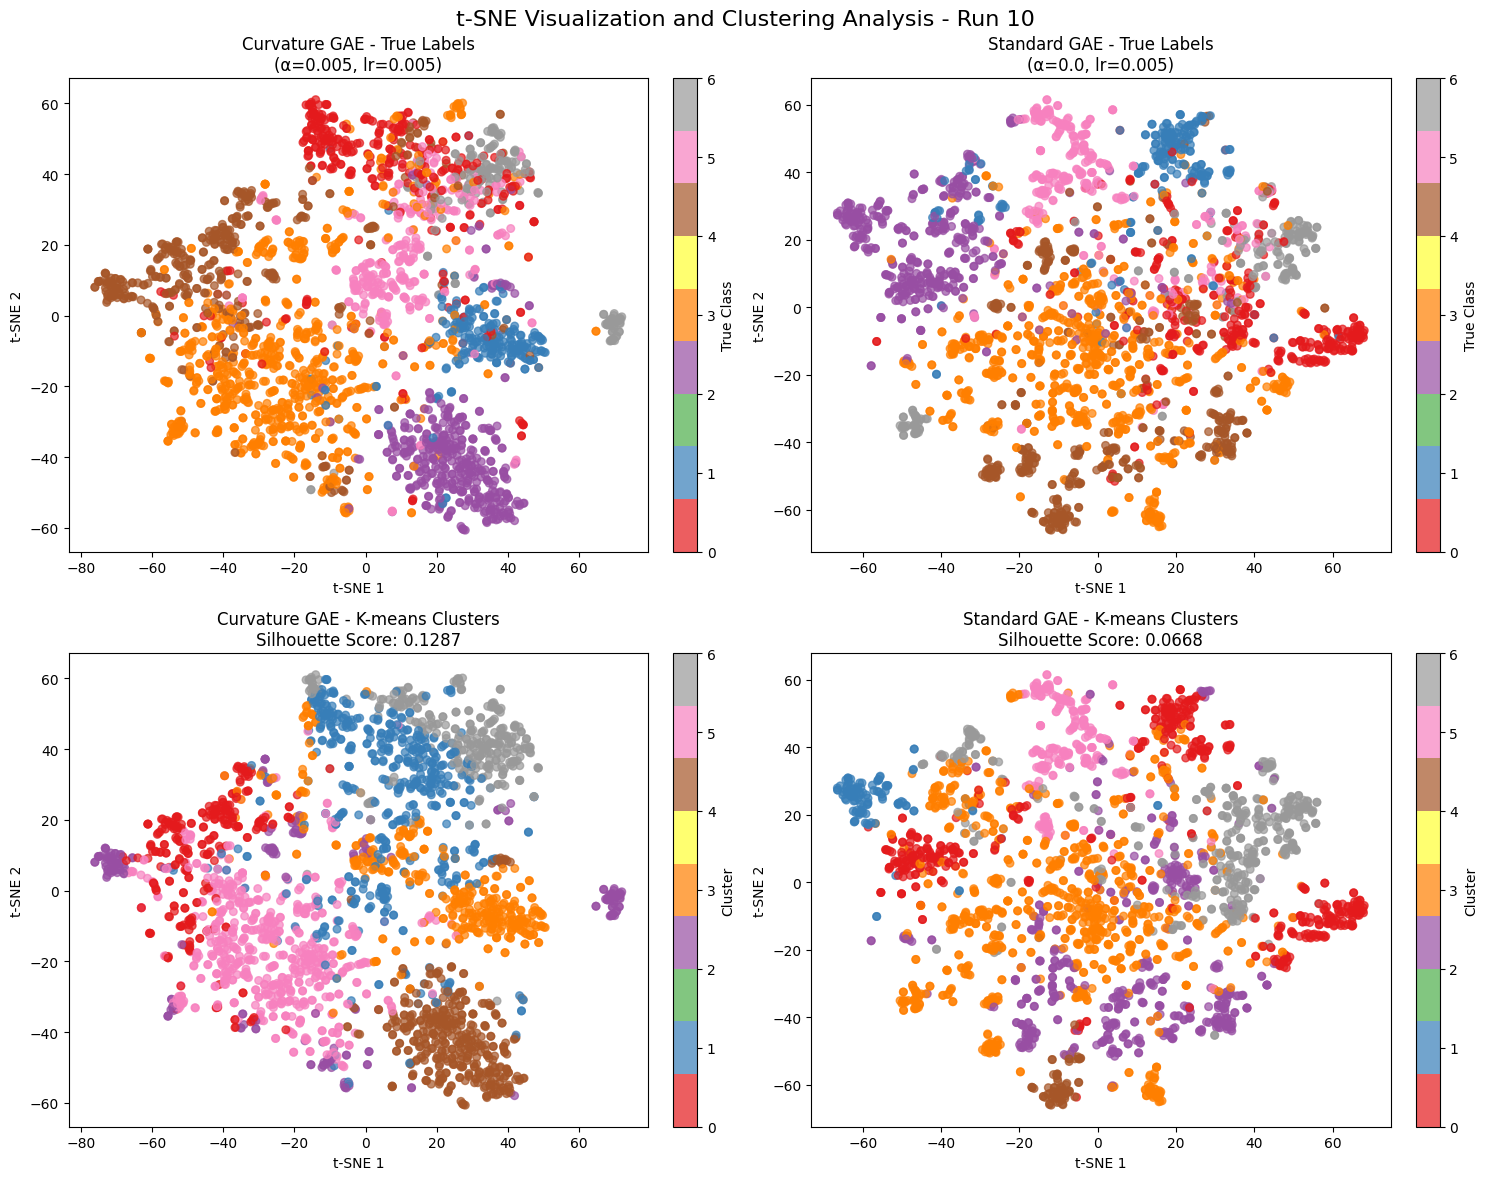


Additional Clustering Metrics:
Adjusted Rand Index:
  Curvature GAE: 0.3409
  Standard GAE: 0.2353
  ARI Improvement: +0.1056
Normalized Mutual Information:
  Curvature GAE: 0.3962
  Standard GAE: 0.3162
  NMI Improvement: +0.0800

t-SNE AND CLUSTERING SUMMARY
Silhouette Score Improvement: +0.0619
ARI Improvement: +0.1056
NMI Improvement: +0.0800


In [3]:

if __name__ == "__main__":
    # Set initial seed
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    print("Loading dataset...")
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]

    print(f"Dataset loaded: {data.x.size(0)} nodes, {data.edge_index.size(1)} edges")
    print(f"Feature dimension: {data.x.size(1)}, Number of classes: {dataset.num_classes}")

    # Store original data
    clean_data = data.clone()
    clean_data_features = data.x.clone()
    clean_data_edge_index = data.edge_index.clone()


    # Convert to NetworkX for initial analysis
    G_nx = to_networkx(data, to_undirected=True)
    if G_nx.number_of_edges() > 3000:
        # Sample edges for initial analysis
        edges_to_remove = list(G_nx.edges())[3000:]
        G_nx.remove_edges_from(edges_to_remove)

    print("--- Initial Geometric Analysis ---")
    initial_curvature = compute_forman_ricci(G_nx)
    target_mean, target_std = get_curvature_stats(initial_curvature, "Original Input Graph")
    
    # Choose what to run
    print(f"\n{'='*60}")
    print("CHOOSE EXPERIMENT TYPE:")
    print("1. Hyperparameter Search")
    print("2. Statistical Robustness Analysis")
    print("3. Both (Recommended)")
    print(f"{'='*60}")

    # For demo, let's run both. In practice, you might want to make this interactive
    run_hyperparameter_search = False
    run_robustness_analysis = True

    # 1. HYPERPARAMETER SEARCH
    if run_hyperparameter_search:
        print(f"\n{'='*60}")
        print("STEP 1: HYPERPARAMETER SEARCH")
        print(f"{'='*60}")

        # Define search space
        alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Curvature regularization strength
        lr_values = [0.0005, 0.001, 0.002, 0.005]        # Learning rates

        best_curv_config, best_std_config, results_df = hyperparameter_search(
            clean_data, (target_mean, target_std),
            alpha_values, lr_values,
            num_runs_per_config=5
        )
        # Show hyperparameter search results
        print(f"\n--- Hyperparameter Search Summary ---")
        print(results_df[['alpha_curv', 'lr', 'curv_mean_acc', 'std_mean_acc', 'mean_acc_improvement']].to_string(index=False))

    # Replace the robustness analysis section in your main execution block with this:
    if run_robustness_analysis:
        if not run_hyperparameter_search:
            # Use default configurations if hyperparameter search wasn't run
            best_curv_config = {'alpha_curv': 0.005, 'lr': 0.005}
            best_std_config = {'alpha_curv': 0, 'lr': 0.005}
        
        # Run robustness analysis with t-SNE visualization
        all_results, tsne_results = run_robustness_with_tsne_analysis(
            clean_data, (target_mean, target_std),
            best_curv_config, best_std_config,
            num_runs=10, noise_level=0.1
        )
        
        print(f"\n{'='*60}")
        print(f"t-SNE AND CLUSTERING SUMMARY")
        print(f"{'='*60}")
        print(f"Silhouette Score Improvement: {tsne_results['silhouette_curv'] - tsne_results['silhouette_std']:+.4f}")
        print(f"ARI Improvement: {tsne_results['ari_curv'] - tsne_results['ari_std']:+.4f}")
        print(f"NMI Improvement: {tsne_results['nmi_curv'] - tsne_results['nmi_std']:+.4f}")

Loading dataset...


Processing...
Done!


Dataset loaded: 3327 nodes, 9104 edges
Feature dimension: 3703, Number of classes: 6
--- Initial Geometric Analysis ---

--- Curvature Statistics: Original Input Graph ---
Mean: -5.5543
Median: -2.0000
Standard Deviation: 10.2153
Skewness: -2.6401
Min: -59.0000, Max: 6.0000
Number of edges: 3000
Negative curvature edges: 1953 (65.1%)
------------------------------------

CHOOSE EXPERIMENT TYPE:
1. Hyperparameter Search
2. Statistical Robustness Analysis
3. Both (Recommended)

STEP 1: HYPERPARAMETER SEARCH

Alpha values: [0.001, 0.005, 0.01, 0.05, 0.1]
Learning rates: [0.0005, 0.001, 0.002, 0.005]
Runs per config: 5
Total experiments: 200

--- Config 1/20: α=0.001, lr=0.0005 ---


C:\Users\as924\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\optim\lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  current = float(metrics)


  Curv GAE: 0.5564 ± 0.0153
  Std GAE:  0.4396 ± 0.0284
  Improvement: +0.1168

--- Config 2/20: α=0.001, lr=0.001 ---
  Curv GAE: 0.5956 ± 0.0190
  Std GAE:  0.4804 ± 0.0302
  Improvement: +0.1152

--- Config 3/20: α=0.001, lr=0.002 ---
  Curv GAE: 0.6056 ± 0.0157
  Std GAE:  0.5420 ± 0.0360
  Improvement: +0.0636

--- Config 4/20: α=0.001, lr=0.005 ---
  Curv GAE: 0.6432 ± 0.0217
  Std GAE:  0.5792 ± 0.0181
  Improvement: +0.0640

--- Config 5/20: α=0.005, lr=0.0005 ---
  Curv GAE: 0.5608 ± 0.0215
  Std GAE:  0.4396 ± 0.0284
  Improvement: +0.1212

--- Config 6/20: α=0.005, lr=0.001 ---
  Curv GAE: 0.5948 ± 0.0325
  Std GAE:  0.4804 ± 0.0302
  Improvement: +0.1144

--- Config 7/20: α=0.005, lr=0.002 ---
  Curv GAE: 0.6116 ± 0.0225
  Std GAE:  0.5420 ± 0.0360
  Improvement: +0.0696

--- Config 8/20: α=0.005, lr=0.005 ---
  Curv GAE: 0.6436 ± 0.0210
  Std GAE:  0.5792 ± 0.0181
  Improvement: +0.0644

--- Config 9/20: α=0.01, lr=0.0005 ---
  Curv GAE: 0.5660 ± 0.0179
  Std GAE:  0.4396 

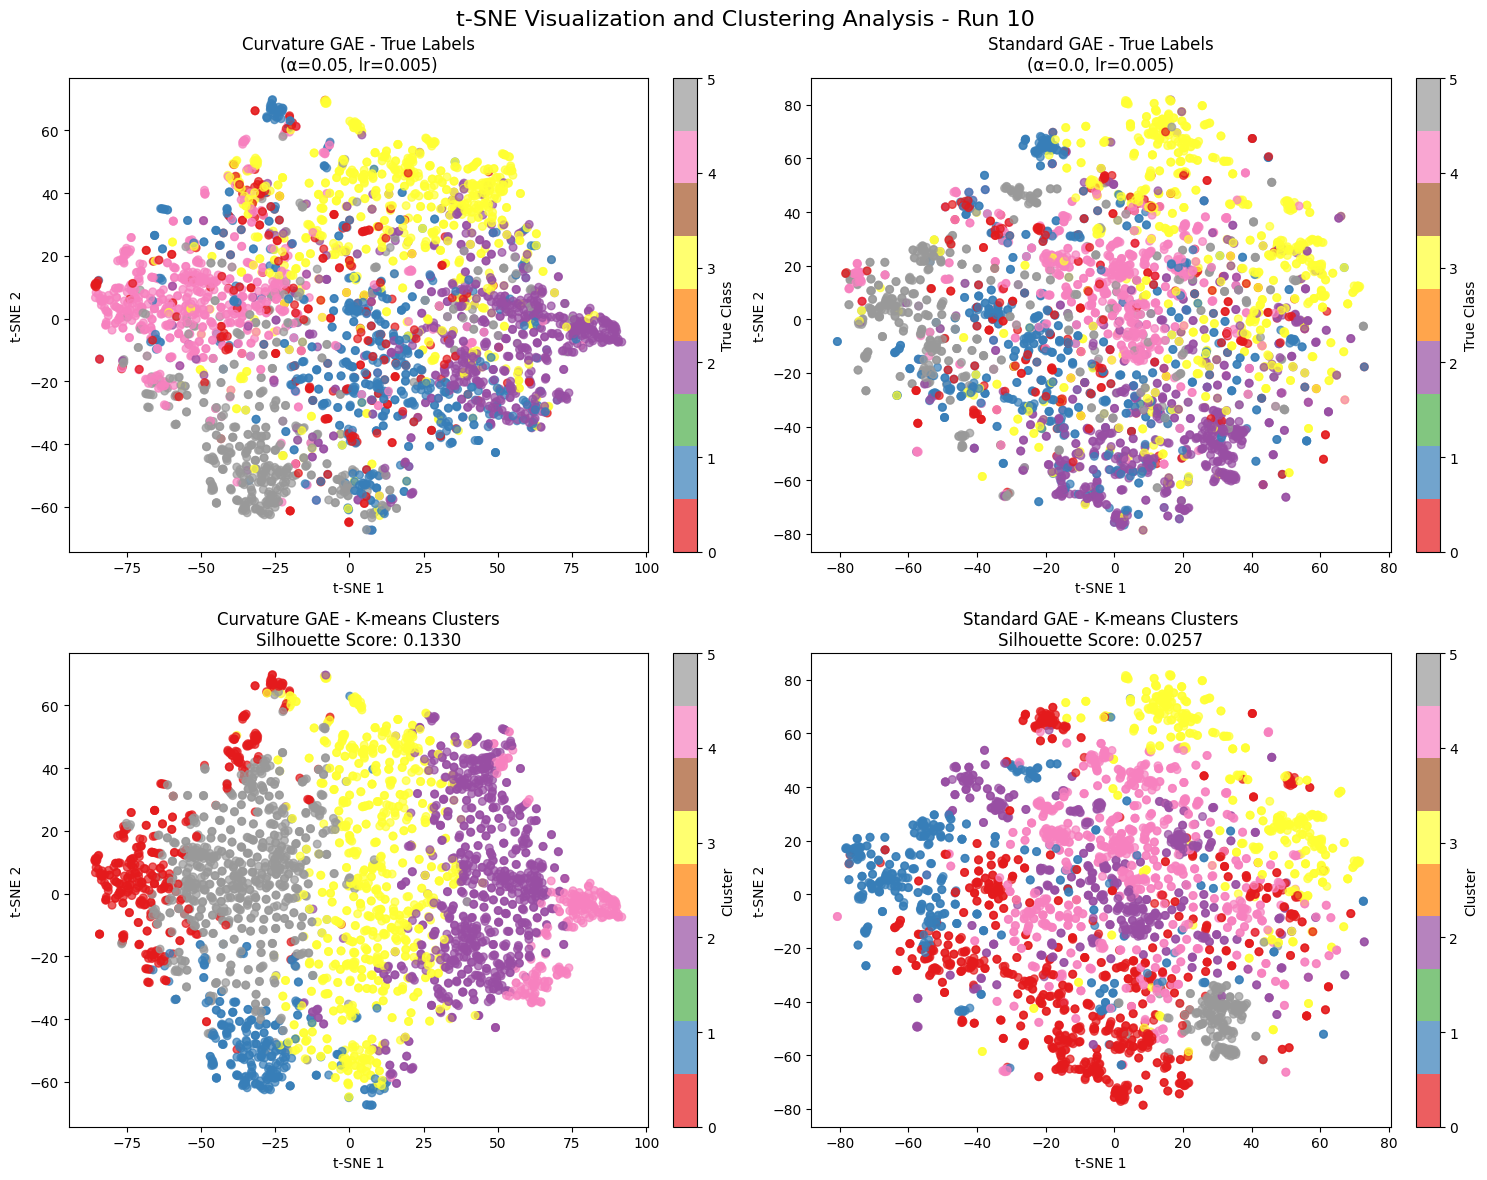


Additional Clustering Metrics:
Adjusted Rand Index:
  Curvature GAE: 0.1677
  Standard GAE: 0.1871
  ARI Improvement: -0.0195
Normalized Mutual Information:
  Curvature GAE: 0.2380
  Standard GAE: 0.2567
  NMI Improvement: -0.0187

t-SNE AND CLUSTERING SUMMARY
Silhouette Score Improvement: +0.1074
ARI Improvement: -0.0195
NMI Improvement: -0.0187


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import pandas as pd
from collections import defaultdict
# Add these additional imports at the top with your existing imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# PyTorch Geometric for GCN and datasets
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.nn import GCNConv

# Scikit-learn for evaluation and visualization
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def set_seed(seed):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# ------------------------------
# 1. Improved Differentiable Forman-Ricci Curvature
# ------------------------------

def compute_edge_curvature_batch(edge_index, adj_matrix, batch_size=1000):
    """
    Memory-efficient computation of differentiable Forman-Ricci curvature.
    Returns negative curvature values to encourage minimization.
    """
    device = adj_matrix.device
    n = adj_matrix.size(0)

    # Compute degrees once
    degrees = torch.sum(adj_matrix, dim=1)  # Shape: (n,)

    # Get actual edges from edge_index
    edges = edge_index.t()  # Shape: (num_edges, 2)
    num_edges = edges.size(0)

    curvatures = []

    # Process edges in batches
    for i in range(0, num_edges, batch_size):
        batch_end = min(i + batch_size, num_edges)
        batch_edges = edges[i:batch_end]  # Shape: (batch_size, 2)

        # Get source and target nodes
        src_nodes = batch_edges[:, 0]  # Shape: (batch_size,)
        tgt_nodes = batch_edges[:, 1]  # Shape: (batch_size,)

        # Get degrees for this batch
        deg_src = degrees[src_nodes]  # Shape: (batch_size,)
        deg_tgt = degrees[tgt_nodes]  # Shape: (batch_size,)

        # Compute common neighbors efficiently
        # For each edge (i,j), common neighbors = sum_k (A[i,k] * A[j,k])
        src_neighbors = adj_matrix[src_nodes]  # Shape: (batch_size, n)
        tgt_neighbors = adj_matrix[tgt_nodes]  # Shape: (batch_size, n)
        common_neighbors = torch.sum(src_neighbors * tgt_neighbors, dim=1)  # Shape: (batch_size,)

        # Forman-Ricci curvature formula: curv = 4 - deg_i - deg_j + 3 * common_neighbors
        batch_curvatures = 4 - deg_src - deg_tgt + 3 * common_neighbors
        curvatures.append(batch_curvatures)

    return torch.cat(curvatures, dim=0)

def adaptive_curvature_loss(edge_index, adj_matrix, target_stats=None, loss_type='minimize'):
    """
    Flexible curvature loss that can minimize, maximize, or match target distribution.

    Args:
        edge_index: Graph edges
        adj_matrix: Adjacency matrix (can be large - we'll sample)
        target_stats: (mean, std) of target curvature distribution
        loss_type: 'minimize', 'maximize', 'match_target', or 'adaptive'
    """
    device = adj_matrix.device
    dtype = adj_matrix.dtype

    # For very large graphs, sample edges to make computation tractable
    if adj_matrix.size(0) > 5000:
        # Sample a subset of edges for curvature computation
        num_edges = edge_index.size(1)
        max_edges = min(2000, num_edges)  # Limit to 2000 edges
        edge_indices = torch.randperm(num_edges, device=device)[:max_edges]
        sampled_edge_index = edge_index[:, edge_indices]
    else:
        sampled_edge_index = edge_index

    # Compute curvature for sampled edges
    edge_curvatures = compute_edge_curvature_batch(sampled_edge_index, adj_matrix, batch_size=500)

    if len(edge_curvatures) == 0:
        return torch.tensor(0.0, device=device, dtype=dtype)

    mean_curvature = torch.mean(edge_curvatures)
    std_curvature = torch.std(edge_curvatures)

    if loss_type == 'minimize':
        # Minimize mean curvature (encourage negative values)
        target_mean = target_stats[0] if target_stats else -2.0
        loss = F.mse_loss(mean_curvature, torch.tensor(target_mean, device=device, dtype=dtype))

    elif loss_type == 'maximize':
        # Maximize mean curvature (encourage positive values)
        target_mean = target_stats[0] if target_stats else 2.0
        loss = F.mse_loss(mean_curvature, torch.tensor(target_mean, device=device, dtype=dtype))

    elif loss_type == 'match_target':
        # Match target curvature statistics
        if target_stats is None:
            return torch.tensor(0.0, device=device, dtype=dtype)

        target_mean, target_std = target_stats
        mean_loss = F.mse_loss(mean_curvature, torch.tensor(target_mean, device=device, dtype=dtype))
        std_loss = F.mse_loss(std_curvature, torch.tensor(target_std, device=device, dtype=dtype))
        loss = mean_loss + 0.5 * std_loss

    elif loss_type == 'adaptive':
        # Let the model learn optimal curvature distribution
        # Encourage diversity in curvature values (avoid collapse)
        variance_loss = torch.exp(-std_curvature)  # Penalize low variance

        # Soft constraint to keep curvatures in reasonable range
        range_penalty = F.relu(torch.abs(mean_curvature) - 10.0)  # Penalize extreme means

        loss = variance_loss + 0.1 * range_penalty

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

    return loss

# ------------------------------
# 2. Traditional Forman-Ricci Curvature for Reference
# ------------------------------

def compute_forman_ricci(G):
    """Returns a dictionary with Forman-Ricci curvature for each edge."""
    curvatures = {}
    for u, v in G.edges():
        if u == v: continue
        degree_u = G.degree[u]
        degree_v = G.degree[v]
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        curv = 4 - degree_u - degree_v + 3 * common_neighbors
        curvatures[(u, v)] = curv
    return curvatures

# ------------------------------
# 3. Improved GCN Model with Better Architecture
# ------------------------------

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels))

        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        # Final layer without activation
        x = self.convs[-1](x, edge_index)
        return x

class GraphAutoencoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_channels, out_channels, num_layers)

        # Improved decoder with multiple layers
        self.decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels, in_channels)
        )

    def forward(self, data, compute_adj=True):
        x, edge_index = data.x, data.edge_index
        z = self.encoder(x, edge_index)
        recon_features = self.decoder(z)

        recon_adj = None
        if compute_adj:
            # Always try to compute adjacency, but use efficient methods for large graphs
            z_normalized = F.normalize(z, p=2, dim=1)

            if z.size(0) <= 4000:
                # For smaller graphs: full dense reconstruction
                recon_adj = torch.mm(z_normalized, z_normalized.t())
                recon_adj = torch.sigmoid(recon_adj)
                # Zero out diagonal (no self-loops)
                recon_adj = recon_adj * (1 - torch.eye(z.size(0), device=z.device))
            else:
                # For larger graphs: sparse reconstruction using existing edges
                src, tgt = edge_index
                edge_weights = torch.sum(z_normalized[src] * z_normalized[tgt], dim=1)
                edge_weights = torch.sigmoid(edge_weights)

                # Create sparse adjacency representation and convert to dense
                # This is still memory efficient as we only compute for existing edges
                recon_adj = torch.zeros(z.size(0), z.size(0), device=z.device, dtype=z.dtype)
                recon_adj[src, tgt] = edge_weights
                recon_adj[tgt, src] = edge_weights  # Make symmetric

        return recon_features, z, recon_adj

# ------------------------------
# 4. Improved Training Function
# ------------------------------

def train(model, data, target_curvature_stats, optimizer, epochs,
          lambda_struct=0.1, alpha_curv=0.01, curvature_loss_type='match_target',
          verbose=True):
    """
    Training function for graph denoising task.

    The model receives noisy features and tries to reconstruct clean features and structure.

    Args:
        curvature_loss_type: 'minimize', 'maximize', 'match_target', or 'adaptive'
    """
    model.train()

    # Ensure data is in float32
    data.x = data.x.float()

    # DENOISING TASK: Targets are the clean original data
    clean_features = clean_data_features
    clean_adj = to_dense_adj(clean_data_edge_index).squeeze(0).float()
    clean_adj = clean_adj * (1 - torch.eye(data.x.size(0), device=data.x.device))

    # Handle large graphs efficiently
    use_full_adj = data.x.size(0) <= 4000

    if verbose:
        print(f"\n--- Training Graph Denoising Model ---")
        print(f"λ_struct={lambda_struct}, α_curv={alpha_curv}")
        print(f"Graph size: {data.x.size(0)} nodes, {data.edge_index.size(1)} edges")
        print(f"Using full adjacency: {use_full_adj}, Curvature loss type: {curvature_loss_type}")
        print(f"Task: Reconstruct CLEAN graph from NOISY input")

        # Show denoising challenge
        feature_mse = F.mse_loss(data.x, clean_features).item()
        print(f"Initial feature MSE (noisy vs clean): {feature_mse:.4f}")

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20)

    # Track losses for consistent reporting
    losses = {'total': [], 'feature': [], 'structure': [], 'curvature': []}

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass - always try to compute adjacency for curvature
        recon_features, z, recon_adj = model(data, compute_adj=True)

        # Loss 1: Feature Denoising Loss
        feature_loss = F.mse_loss(recon_features, clean_features)

        # Loss 2: Structure Reconstruction Loss (reconstruct clean adjacency)
        structure_loss = torch.tensor(0.0, dtype=data.x.dtype, device=data.x.device)
        if use_full_adj and recon_adj is not None:
            structure_loss = F.binary_cross_entropy(recon_adj, clean_adj)

        # Loss 3: Curvature Regularization (encourage clean curvature properties)
        curvature_loss = torch.tensor(0.0, dtype=data.x.dtype, device=data.x.device)
        if alpha_curv > 0 and recon_adj is not None:
            # Apply curvature regularization to the reconstructed adjacency
            # Target: original clean graph's curvature statistics
            curvature_loss = adaptive_curvature_loss(
                clean_data_edge_index, recon_adj, target_curvature_stats, curvature_loss_type
            )

        # Add L2 regularization
        l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
        total_loss = feature_loss + (lambda_struct * structure_loss) + (alpha_curv * curvature_loss) + 1e-5 * l2_reg

        total_loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(total_loss)

        # Store losses for analysis
        losses['total'].append(total_loss.item())
        losses['feature'].append(feature_loss.item())
        losses['structure'].append(structure_loss.item())
        losses['curvature'].append(curvature_loss.item())

        if verbose and epoch % 25 == 0:
            print(f"Epoch {epoch:03d}, Loss: {total_loss.item():.4f}, "
                  f"Feat: {feature_loss.item():.4f}, Struct: {structure_loss.item():.4f}, "
                  f"Curv: {curvature_loss.item():.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Clear cache periodically
        if epoch % 100 == 0:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return model

# ------------------------------
# 5. Enhanced Analysis Functions
# ------------------------------

def analyze_reconstructed_curvature(model, data, title="Reconstructed Graph", max_edges=2000):
    """Enhanced analysis of reconstructed curvature."""
    model.eval()
    with torch.no_grad():
        _, z, recon_adj = model(data, compute_adj=True)

        if recon_adj is None:
            print(f"Skipping curvature analysis for {title} (graph too large)")
            return {}, None

        # Convert to NetworkX with edge limit
        adj_np = recon_adj.cpu().numpy()
        adj_binary = (adj_np > 0.3).astype(int)  # Higher threshold for cleaner graph

        # Create NetworkX graph
        G_recon = nx.from_numpy_array(adj_binary)

        # Remove isolated nodes and limit edges
        G_recon.remove_nodes_from(list(nx.isolates(G_recon)))
        if G_recon.number_of_edges() > max_edges:
            # Keep edges with highest weights
            edges_with_weights = [(u, v, adj_np[u, v]) for u, v in G_recon.edges()]
            edges_with_weights.sort(key=lambda x: x[2], reverse=True)
            edges_to_keep = [(u, v) for u, v, w in edges_with_weights[:max_edges]]
            G_recon = nx.Graph()
            G_recon.add_edges_from(edges_to_keep)

        recon_curvature = compute_forman_ricci(G_recon)
        return recon_curvature, G_recon

def get_curvature_stats(curv_dict, title, verbose=True):
    """Enhanced curvature statistics."""
    if not curv_dict:
        if verbose:
            print(f"No curvature data for '{title}'.")
        return None, None

    values = np.array(list(curv_dict.values()))
    mean = np.mean(values)
    std = np.std(values)
    median = np.median(values)
    skewness = skew(values)
    min_val = np.min(values)
    max_val = np.max(values)

    if verbose:
        print(f"\n--- Curvature Statistics: {title} ---")
        print(f"Mean: {mean:.4f}")
        print(f"Median: {median:.4f}")
        print(f"Standard Deviation: {std:.4f}")
        print(f"Skewness: {skewness:.4f}")
        print(f"Min: {min_val:.4f}, Max: {max_val:.4f}")
        print(f"Number of edges: {len(values)}")
        print(f"Negative curvature edges: {np.sum(values < 0)} ({100*np.sum(values < 0)/len(values):.1f}%)")
        print("------------------------------------")

    return mean, std

def evaluate_node_classification_hyper(z, data):
    """Enhanced node classification evaluation."""
    X = z.detach().cpu().numpy()
    y = data.y.cpu().numpy()

    X_train = X[data.train_mask]
    y_train = y[data.train_mask]
    X_test = X[data.val_mask]
    y_test = y[data.val_mask]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Try different solvers and regularization
    best_acc = 0
    for C in [0.01, 0.1, 1.0, 10.0]:
        classifier = LogisticRegression(
            solver='lbfgs', max_iter=2000, random_state=42, C=C
        )
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > best_acc:
            best_acc = acc

    return best_acc

def final_evaluate_node_classification(z, data):
    """Enhanced node classification evaluation."""
    X = z.detach().cpu().numpy()
    y = data.y.cpu().numpy()

    X_train = X[data.train_mask]
    y_train = y[data.train_mask]
    X_test = X[data.test_mask]
    y_test = y[data.test_mask]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Try different solvers and regularization
    best_acc = 0
    for C in [0.01, 0.1, 1.0, 10.0]:
        classifier = LogisticRegression(
            solver='lbfgs', max_iter=2000, random_state=42, C=C
        )
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > best_acc:
            best_acc = acc

    return best_acc


# ------------------------------
# 6. Statistical Analysis Functions
# ------------------------------

def compute_statistics(values):
    """Compute comprehensive statistics for a list of values."""
    values = np.array(values)
    return {
        'mean': np.mean(values),
        'std': np.std(values),
        'median': np.median(values),
        'min': np.min(values),
        'max': np.max(values),
        'q25': np.percentile(values, 25),
        'q75': np.percentile(values, 75)
    }

def print_statistical_summary(results_dict, metric_name):
    """Print statistical summary for multiple runs."""
    print(f"\n=== Statistical Summary: {metric_name} ===")

    for model_type, values in results_dict.items():
        stats = compute_statistics(values)
        print(f"\n{model_type}:")
        print(f"  Mean ± Std: {stats['mean']:.4f} ± {stats['std']:.4f}")
        print(f"  Median [Q25, Q75]: {stats['median']:.4f} [{stats['q25']:.4f}, {stats['q75']:.4f}]")
        print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")

# ------------------------------
# 8. Hyperparameter Tuning Functions
# ------------------------------

def hyperparameter_search(data, target_stats, alpha_values, lr_values, num_runs_per_config=5):
    """
    Perform grid search over alpha_curv and learning rate.

    Args:
        data: Graph data
        target_stats: Target curvature statistics
        alpha_values: List of alpha_curv values to try
        lr_values: List of learning rates to try
        num_runs_per_config: Number of runs per hyperparameter configuration

    Returns:
        best_config, results_df
    """
    print(f"\n{'='*60}")
    print(f"Alpha values: {alpha_values}")
    print(f"Learning rates: {lr_values}")
    print(f"Runs per config: {num_runs_per_config}")
    print(f"Total experiments: {len(alpha_values) * len(lr_values) * num_runs_per_config * 2}")  # *2 for curv vs std
    print(f"{'='*60}")

    results = []
    config_id = 0

    for alpha_curv in alpha_values:
        for lr in lr_values:
            config_id += 1
            print(f"\n--- Config {config_id}/{len(alpha_values) * len(lr_values)}: α={alpha_curv}, lr={lr} ---")

            # Store results for this configuration
            config_results = {
                'alpha_curv': alpha_curv,
                'lr': lr,
                'curv_accuracies': [],
                'std_accuracies': [],
            }
            seed_values = [2,12,22,32,42,52,62,72,82,92]
            for run in range(num_runs_per_config):
                # Create fresh copy of data
                data_copy = data.clone()

                # Train curvature-regularized model
                set_seed(seed_values[run])  # Different seed for model initialization
                curv_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
                optimizer = torch.optim.Adam(curv_model.parameters(), lr=lr, weight_decay=1e-4)

                curv_model = train(
                    curv_model, data_copy, target_stats, optimizer,
                    epochs=150, lambda_struct=1.0, alpha_curv=alpha_curv,
                    curvature_loss_type='match_target', verbose=False
                )

                # Train standard model
                set_seed(seed_values[run])  # Same seed for fair comparison
                std_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
                optimizer_std = torch.optim.Adam(std_model.parameters(), lr=lr, weight_decay=1e-4)

                std_model = train(
                    std_model, data_copy, target_stats, optimizer_std,
                    epochs=150, lambda_struct=1.0, alpha_curv=0.0,
                    curvature_loss_type='adaptive', verbose=False
                )

                # Evaluate both models
                curv_model.eval()
                std_model.eval()

                with torch.no_grad():
                    _, z_curv, _ = curv_model(data_copy, compute_adj=False)
                    _, z_std, _ = std_model(data_copy, compute_adj=False)

                    # Node classification
                    acc_curv = evaluate_node_classification_hyper(z_curv, data_copy)
                    acc_std = evaluate_node_classification_hyper(z_std, data_copy)

                    config_results['curv_accuracies'].append(acc_curv)
                    config_results['std_accuracies'].append(acc_std)
                # Clean up
                del curv_model, std_model
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

            # Compute averages for this configuration
            config_summary = {
                'alpha_curv': alpha_curv,
                'lr': lr,
                'curv_mean_acc': np.mean(config_results['curv_accuracies']),
                'curv_std_acc': np.std(config_results['curv_accuracies']),
                'std_mean_acc': np.mean(config_results['std_accuracies']),
                'std_std_acc': np.std(config_results['std_accuracies']),
                'mean_acc_improvement': np.mean(config_results['curv_accuracies']) - np.mean(config_results['std_accuracies']),
                'std_acc_improvement': np.std(np.array(config_results['curv_accuracies']) - np.array(config_results['std_accuracies'])),
            }

            results.append(config_summary)
            print(f"  Curv GAE: {config_summary['curv_mean_acc']:.4f} ± {config_summary['curv_std_acc']:.4f}")
            print(f"  Std GAE:  {config_summary['std_mean_acc']:.4f} ± {config_summary['std_std_acc']:.4f}")
            print(f"  Improvement: {config_summary['mean_acc_improvement']:+.4f}")


    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)

    # Find best configuration based on accuracy improvement
    best_curv_idx = results_df['curv_mean_acc'].idxmax()
    best_curv_config = results_df.iloc[best_curv_idx]

    best_std_idx = results_df['std_mean_acc'].idxmax()
    best_std_config = results_df.iloc[best_std_idx]

    print(f"\n{'='*60}")
    print(f"INDEPENDENT HYPERPARAMETER SEARCH RESULTS")
    print(f"{'='*60}")
    
    print(f"\nBest configuration for CURVATURE-REGULARIZED GAE:")
    print(f"  Alpha: {best_curv_config['alpha_curv']}")
    print(f"  Learning rate: {best_curv_config['lr']}")
    print(f"  Validation accuracy: {best_curv_config['curv_mean_acc']:.4f} ± {best_curv_config['curv_std_acc']:.4f}")
    
    print(f"\nBest configuration for STANDARD GAE:")
    print(f"  Alpha: {best_std_config['alpha_curv']} (ignored)")
    print(f"  Learning rate: {best_std_config['lr']}")
    print(f"  Validation accuracy: {best_std_config['std_mean_acc']:.4f} ± {best_std_config['std_std_acc']:.4f}")

    # Show if they happen to use the same learning rate
    if best_curv_config['lr'] == best_std_config['lr']:
        print(f"\n📝 Note: Both models achieved best performance with lr={best_curv_config['lr']}")
        shared_lr = best_curv_config['lr']
    else:
        print(f"\n📝 Note: Models prefer different learning rates")
        print(f"   Curvature GAE: lr={best_curv_config['lr']}")
        print(f"   Standard GAE: lr={best_std_config['lr']}")
        shared_lr = None

    # Show top configurations for each model
    print(f"\nTop 3 configurations for Curvature-Regularized GAE:")
    top_curv = results_df.nlargest(3, 'curv_mean_acc')
    for i, (_, row) in enumerate(top_curv.iterrows()):
        print(f"  {i+1}. α={row['alpha_curv']}, lr={row['lr']}: {row['curv_mean_acc']:.4f}")

    print(f"\nTop 3 configurations for Standard GAE:")
    top_std = results_df.nlargest(3, 'std_mean_acc')
    for i, (_, row) in enumerate(top_std.iterrows()):
        print(f"  {i+1}. α={row['alpha_curv']}, lr={row['lr']}: {row['std_mean_acc']:.4f}")

    # Optional: Show performance when both use the same hyperparameters
    if shared_lr is not None:
        shared_config = results_df[results_df['lr'] == shared_lr]
        if len(shared_config) > 0:
            best_shared = shared_config.loc[shared_config['curv_mean_acc'].idxmax()]
            print(f"\nFair comparison using shared lr={shared_lr}, α={best_shared['alpha_curv']}:")
            print(f"  Curvature GAE: {best_shared['curv_mean_acc']:.4f} ± {best_shared['curv_std_acc']:.4f}")
            print(f"  Standard GAE:  {best_shared['std_mean_acc']:.4f} ± {best_shared['std_std_acc']:.4f}")
            print(f"  Improvement:   {best_shared['mean_acc_improvement']:+.4f}")

    return best_curv_config, best_std_config, results_df

def run_robustness_with_independent_hyperparams(data, target_stats, best_curv_config, best_std_config, 
                                               num_runs=10, noise_level=0.0):
    """
    Run robustness analysis using independently selected hyperparameters for each model.
    """
    print(f"\n{'='*60}")
    print(f"ROBUSTNESS ANALYSIS WITH INDEPENDENT HYPERPARAMETERS")
    print(f"Curvature GAE: α={best_curv_config['alpha_curv']}, lr={best_curv_config['lr']}")
    print(f"Standard GAE: α=0.0, lr={best_std_config['lr']}")
    print(f"Number of runs: {num_runs}")
    print(f"Noise level: {noise_level}")
    print(f"{'='*60}")

    # Storage for results across multiple runs
    all_results = {
        'curv_accuracy': [],
        'std_accuracy': [],
        'accuracy_improvement': []
    }
    seed_values = [2,12,22,32,42,52,62,72,82,92]
    # Run multiple experiments
    for run_id in range(num_runs):
        # Create fresh copy of data for each run
        data_copy = data.clone()
        
        # Add noise if specified
        if noise_level > 0:
            noise = torch.randn_like(data_copy.x) * noise_level
            data_copy.x = data_copy.x + noise

        # Train curvature-regularized model with its best hyperparameters
        set_seed(seed_values[run_id])
        curv_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
        optimizer_curv = torch.optim.Adam(
            curv_model.parameters(), 
            lr=best_curv_config['lr'], 
            weight_decay=1e-4
        )

        curv_model = train(
            curv_model, data_copy, target_stats, optimizer_curv,
            epochs=200, lambda_struct=1.0, alpha_curv=best_curv_config['alpha_curv'],
            curvature_loss_type='match_target', verbose=(run_id == 0)
        )

        # Train standard model with its best hyperparameters
        set_seed(seed_values[run_id])  # Same seed for model initialization
        std_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
        optimizer_std = torch.optim.Adam(
            std_model.parameters(), 
            lr=best_std_config['lr'], 
            weight_decay=1e-4
        )

        std_model = train(
            std_model, data_copy, target_stats, optimizer_std,
            epochs=200, lambda_struct=1.0, alpha_curv=0.0,
            curvature_loss_type='adaptive', verbose=False
        )

        # Evaluate both models
        curv_model.eval()
        std_model.eval()

        with torch.no_grad():
            _, z_curv, _ = curv_model(data_copy, compute_adj=False)
            _, z_std, _ = std_model(data_copy, compute_adj=False)

            # Final evaluation on test set
            acc_curv = final_evaluate_node_classification(z_curv, data_copy)
            acc_std = final_evaluate_node_classification(z_std, data_copy)

            all_results['curv_accuracy'].append(acc_curv)
            all_results['std_accuracy'].append(acc_std)
            all_results['accuracy_improvement'].append(acc_curv - acc_std)

        acc_improvement = acc_curv - acc_std
        print(f"Run {run_id + 1}/{num_runs} completed - Acc improvement: {acc_improvement:+.4f}")

        # Clean up memory
        del curv_model, std_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Statistical Analysis
    print(f"\n{'='*60}")
    print(f"STATISTICAL RESULTS (INDEPENDENT HYPERPARAMETERS)")
    print(f"{'='*60}")

    # Classification accuracy comparison
    accuracy_results = {
        'Curvature-Regularized GAE': all_results['curv_accuracy'],
        'Standard GAE': all_results['std_accuracy']
    }

    print_statistical_summary(accuracy_results, "Node Classification Accuracy")

    # Improvement analysis
    improvement_stats = compute_statistics(all_results['accuracy_improvement'])
    print(f"\n=== Classification Accuracy Improvement Analysis ===")
    print(f"Mean Improvement: {improvement_stats['mean']:.4f} ± {improvement_stats['std']:.4f}")
    print(f"Median [Q25, Q75]: {improvement_stats['median']:.4f} [{improvement_stats['q25']:.4f}, {improvement_stats['q75']:.4f}]")

    # Statistical significance test
    from scipy import stats
    if len(all_results['curv_accuracy']) > 1 and len(all_results['std_accuracy']) > 1:
        t_stat, p_value = stats.ttest_rel(all_results['curv_accuracy'], all_results['std_accuracy'])
        print(f"Paired t-test p-value: {p_value:.4f}")
        print(f"Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")

    # Final summary
    print(f"\n{'='*60}")
    print(f"FINAL SUMMARY")
    print(f"{'='*60}")
    print(f"Curvature GAE (α={best_curv_config['alpha_curv']}, lr={best_curv_config['lr']}): {np.mean(all_results['curv_accuracy']):.4f} ± {np.std(all_results['curv_accuracy']):.4f}")
    print(f"Standard GAE (α=0.0, lr={best_std_config['lr']}): {np.mean(all_results['std_accuracy']):.4f} ± {np.std(all_results['std_accuracy']):.4f}")
    print(f"Improvement: {improvement_stats['mean']:+.4f} ± {improvement_stats['std']:.4f}")

    if p_value < 0.05:
        print(f"\n✅ Results are statistically significant (p={p_value:.4f})")
    else:
        print(f"\n⚠️  Results are not statistically significant (p={p_value:.4f})")

    return all_results

# Add these functions after your existing functions (around line 600-700)

def find_closest_run_to_mean(all_results):
    """
    Find the run whose accuracy is closest to the mean accuracy.
    Returns the index of that run.
    """
    curv_accuracies = np.array(all_results['curv_accuracy'])
    std_accuracies = np.array(all_results['std_accuracy'])
    
    # Calculate mean accuracies
    mean_curv_acc = np.mean(curv_accuracies)
    mean_std_acc = np.mean(std_accuracies)
    
    # Find run closest to mean for curvature model
    curv_distances = np.abs(curv_accuracies - mean_curv_acc)
    closest_curv_run = np.argmin(curv_distances)
    
    # Find run closest to mean for standard model  
    std_distances = np.abs(std_accuracies - mean_std_acc)
    closest_std_run = np.argmin(std_distances)
    
    print(f"Run closest to mean accuracy:")
    print(f"  Curvature GAE: Run {closest_curv_run + 1} (acc: {curv_accuracies[closest_curv_run]:.4f}, mean: {mean_curv_acc:.4f})")
    print(f"  Standard GAE: Run {closest_std_run + 1} (acc: {std_accuracies[closest_std_run]:.4f}, mean: {mean_std_acc:.4f})")
    
    # For simplicity, use the curvature model's closest run for both
    return closest_curv_run

def run_tsne_analysis(data, target_stats, best_curv_config, best_std_config, run_index):
    """
    Run the specified run index and perform t-SNE analysis with clustering.
    """
    print(f"\n{'='*60}")
    print(f"t-SNE AND CLUSTERING ANALYSIS - RUN {run_index + 1}")
    print(f"{'='*60}")
    
    seed_values = [2,12,22,32,42,52,62,72,82,92]
    
    # Create fresh copy of data
    data_copy = data.clone()
    
    # Train curvature-regularized model
    print("Training Curvature-Regularized GAE...")
    set_seed(seed_values[run_index])
    curv_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
    optimizer_curv = torch.optim.Adam(
        curv_model.parameters(), 
        lr=best_curv_config['lr'], 
        weight_decay=1e-4
    )
    
    curv_model = train(
        curv_model, data_copy, target_stats, optimizer_curv,
        epochs=200, lambda_struct=1.0, alpha_curv=best_curv_config['alpha_curv'],
        curvature_loss_type='match_target', verbose=False
    )
    
    # Train standard model
    print("Training Standard GAE...")
    set_seed(seed_values[run_index])
    std_model = GraphAutoencoder(data_copy.x.size(1), 64, 32, num_layers=2)
    optimizer_std = torch.optim.Adam(
        std_model.parameters(), 
        lr=best_std_config['lr'], 
        weight_decay=1e-4
    )
    
    std_model = train(
        std_model, data_copy, target_stats, optimizer_std,
        epochs=200, lambda_struct=1.0, alpha_curv=0.0,
        curvature_loss_type='adaptive', verbose=False
    )
    
    # Get embeddings
    curv_model.eval()
    std_model.eval()
    
    with torch.no_grad():
        _, z_curv, _ = curv_model(data_copy, compute_adj=False)
        _, z_std, _ = std_model(data_copy, compute_adj=False)
    
    # Convert to numpy
    z_curv_np = z_curv.cpu().numpy()
    z_std_np = z_std.cpu().numpy()
    labels = data_copy.y.cpu().numpy()
    
    # Perform t-SNE
    print("Computing t-SNE embeddings...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    
    # t-SNE for curvature model
    tsne_curv = tsne.fit_transform(z_curv_np)
    
    # t-SNE for standard model (refit to avoid potential issues)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    tsne_std = tsne.fit_transform(z_std_np)
    
    # Clustering analysis
    print("Performing clustering analysis...")
    n_clusters = len(np.unique(labels))  # Use true number of classes
    
    # K-means clustering
    kmeans_curv = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_std = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    cluster_labels_curv = kmeans_curv.fit_predict(z_curv_np)
    cluster_labels_std = kmeans_std.fit_predict(z_std_np)
    
    # Silhouette scores
    sil_curv = silhouette_score(z_curv_np, cluster_labels_curv)
    sil_std = silhouette_score(z_std_np, cluster_labels_std)
    
    print(f"\nClustering Results:")
    print(f"  Curvature GAE Silhouette Score: {sil_curv:.4f}")
    print(f"  Standard GAE Silhouette Score: {sil_std:.4f}")
    print(f"  Silhouette Improvement: {sil_curv - sil_std:+.4f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f't-SNE Visualization and Clustering Analysis - Run {run_index + 1}', fontsize=16)
    
    # Define colors for classes
    n_classes = len(np.unique(labels))
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    # Plot 1: Curvature GAE - True Labels
    scatter1 = axes[0, 0].scatter(tsne_curv[:, 0], tsne_curv[:, 1], c=labels, cmap='Set1', alpha=0.7, s=30)
    axes[0, 0].set_title(f'Curvature GAE - True Labels\n(α={best_curv_config["alpha_curv"]}, lr={best_curv_config["lr"]})')
    axes[0, 0].set_xlabel('t-SNE 1')
    axes[0, 0].set_ylabel('t-SNE 2')
    
    # Plot 2: Standard GAE - True Labels  
    scatter2 = axes[0, 1].scatter(tsne_std[:, 0], tsne_std[:, 1], c=labels, cmap='Set1', alpha=0.7, s=30)
    axes[0, 1].set_title(f'Standard GAE - True Labels\n(α=0.0, lr={best_std_config["lr"]})')
    axes[0, 1].set_xlabel('t-SNE 1')
    axes[0, 1].set_ylabel('t-SNE 2')
    
    # Plot 3: Curvature GAE - K-means Clusters
    scatter3 = axes[1, 0].scatter(tsne_curv[:, 0], tsne_curv[:, 1], c=cluster_labels_curv, cmap='Set1', alpha=0.7, s=30)
    axes[1, 0].set_title(f'Curvature GAE - K-means Clusters\nSilhouette Score: {sil_curv:.4f}')
    axes[1, 0].set_xlabel('t-SNE 1')
    axes[1, 0].set_ylabel('t-SNE 2')
    
    # Plot 4: Standard GAE - K-means Clusters
    scatter4 = axes[1, 1].scatter(tsne_std[:, 0], tsne_std[:, 1], c=cluster_labels_std, cmap='Set1', alpha=0.7, s=30)
    axes[1, 1].set_title(f'Standard GAE - K-means Clusters\nSilhouette Score: {sil_std:.4f}')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    
    # Add colorbars for true labels
    cbar1 = plt.colorbar(scatter1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    cbar1.set_label('True Class')
    cbar2 = plt.colorbar(scatter2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    cbar2.set_label('True Class')
    
    # Add colorbars for clusters
    cbar3 = plt.colorbar(scatter3, ax=axes[1, 0], fraction=0.046, pad=0.04)
    cbar3.set_label('Cluster')
    cbar4 = plt.colorbar(scatter4, ax=axes[1, 1], fraction=0.046, pad=0.04)
    cbar4.set_label('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Additional clustering metrics
    # Clustering quality compared to true labels
    ari_curv = adjusted_rand_score(labels, cluster_labels_curv)
    ari_std = adjusted_rand_score(labels, cluster_labels_std)
    
    nmi_curv = normalized_mutual_info_score(labels, cluster_labels_curv)
    nmi_std = normalized_mutual_info_score(labels, cluster_labels_std)
    
    print(f"\nAdditional Clustering Metrics:")
    print(f"Adjusted Rand Index:")
    print(f"  Curvature GAE: {ari_curv:.4f}")
    print(f"  Standard GAE: {ari_std:.4f}")
    print(f"  ARI Improvement: {ari_curv - ari_std:+.4f}")
    
    print(f"Normalized Mutual Information:")
    print(f"  Curvature GAE: {nmi_curv:.4f}")
    print(f"  Standard GAE: {nmi_std:.4f}")
    print(f"  NMI Improvement: {nmi_curv - nmi_std:+.4f}")
    
    # Clean up memory
    del curv_model, std_model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return {
        'silhouette_curv': sil_curv,
        'silhouette_std': sil_std,
        'ari_curv': ari_curv,
        'ari_std': ari_std,
        'nmi_curv': nmi_curv,
        'nmi_std': nmi_std,
        'tsne_curv': tsne_curv,
        'tsne_std': tsne_std,
        'cluster_labels_curv': cluster_labels_curv,
        'cluster_labels_std': cluster_labels_std
    }

def run_robustness_with_tsne_analysis(data, target_stats, best_curv_config, best_std_config, 
                                     num_runs=10, noise_level=0.0):
    """
    Run robustness analysis and then perform t-SNE analysis on the run closest to mean.
    """
    # First run the standard robustness analysis
    all_results = run_robustness_with_independent_hyperparams(
        data, target_stats, best_curv_config, best_std_config, num_runs, noise_level
    )
    
    # Find the run closest to mean
    closest_run_idx = find_closest_run_to_mean(all_results)
    
    # Run t-SNE analysis for that specific run
    tsne_results = run_tsne_analysis(
        data, target_stats, best_curv_config, best_std_config, closest_run_idx
    )
    
    return all_results, tsne_results

if __name__ == "__main__":
    # Set initial seed
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    print("Loading dataset...")
    dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer')
    data = dataset[0]

    print(f"Dataset loaded: {data.x.size(0)} nodes, {data.edge_index.size(1)} edges")
    print(f"Feature dimension: {data.x.size(1)}, Number of classes: {dataset.num_classes}")

    # Store original data
    clean_data = data.clone()
    clean_data_features = data.x.clone()
    clean_data_edge_index = data.edge_index.clone()


    # Convert to NetworkX for initial analysis
    G_nx = to_networkx(data, to_undirected=True)
    if G_nx.number_of_edges() > 3000:
        # Sample edges for initial analysis
        edges_to_remove = list(G_nx.edges())[3000:]
        G_nx.remove_edges_from(edges_to_remove)

    print("--- Initial Geometric Analysis ---")
    initial_curvature = compute_forman_ricci(G_nx)
    target_mean, target_std = get_curvature_stats(initial_curvature, "Original Input Graph")
    
    # Choose what to run
    print(f"\n{'='*60}")
    print("CHOOSE EXPERIMENT TYPE:")
    print("1. Hyperparameter Search")
    print("2. Statistical Robustness Analysis")
    print("3. Both (Recommended)")
    print(f"{'='*60}")

    # For demo, let's run both. In practice, you might want to make this interactive
    run_hyperparameter_search = True
    run_robustness_analysis = True

    # 1. HYPERPARAMETER SEARCH
    if run_hyperparameter_search:
        print(f"\n{'='*60}")
        print("STEP 1: HYPERPARAMETER SEARCH")
        print(f"{'='*60}")

        # Define search space
        alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Curvature regularization strength
        lr_values = [0.0005, 0.001, 0.002, 0.005]        # Learning rates

        best_curv_config, best_std_config, results_df = hyperparameter_search(
            clean_data, (target_mean, target_std),
            alpha_values, lr_values,
            num_runs_per_config=5
        )
        # Show hyperparameter search results
        print(f"\n--- Hyperparameter Search Summary ---")
        print(results_df[['alpha_curv', 'lr', 'curv_mean_acc', 'std_mean_acc', 'mean_acc_improvement']].to_string(index=False))

    # Replace the robustness analysis section in your main execution block with this:
    if run_robustness_analysis:
        if not run_hyperparameter_search:
            # Use default configurations if hyperparameter search wasn't run
            best_curv_config = {'alpha_curv': 0.005, 'lr': 0.005}
            best_std_config = {'alpha_curv': 0, 'lr': 0.005}
        
        # Run robustness analysis with t-SNE visualization
        all_results, tsne_results = run_robustness_with_tsne_analysis(
            clean_data, (target_mean, target_std),
            best_curv_config, best_std_config,
            num_runs=10, noise_level=0
        )
        
        print(f"\n{'='*60}")
        print(f"t-SNE AND CLUSTERING SUMMARY")
        print(f"{'='*60}")
        print(f"Silhouette Score Improvement: {tsne_results['silhouette_curv'] - tsne_results['silhouette_std']:+.4f}")
        print(f"ARI Improvement: {tsne_results['ari_curv'] - tsne_results['ari_std']:+.4f}")
        print(f"NMI Improvement: {tsne_results['nmi_curv'] - tsne_results['nmi_std']:+.4f}")

In [5]:
if __name__ == "__main__":
    # Set initial seed
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    print("Loading dataset...")
    dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer')
    data = dataset[0]

    print(f"Dataset loaded: {data.x.size(0)} nodes, {data.edge_index.size(1)} edges")
    print(f"Feature dimension: {data.x.size(1)}, Number of classes: {dataset.num_classes}")

    # Store original data
    clean_data = data.clone()
    clean_data_features = data.x.clone()
    clean_data_edge_index = data.edge_index.clone()


    # Convert to NetworkX for initial analysis
    G_nx = to_networkx(data, to_undirected=True)
    if G_nx.number_of_edges() > 3000:
        # Sample edges for initial analysis
        edges_to_remove = list(G_nx.edges())[3000:]
        G_nx.remove_edges_from(edges_to_remove)

    print("--- Initial Geometric Analysis ---")
    initial_curvature = compute_forman_ricci(G_nx)
    target_mean, target_std = get_curvature_stats(initial_curvature, "Original Input Graph")
    
    # Choose what to run
    print(f"\n{'='*60}")
    print("CHOOSE EXPERIMENT TYPE:")
    print("1. Hyperparameter Search")
    print("2. Statistical Robustness Analysis")
    print("3. Both (Recommended)")
    print(f"{'='*60}")

    # For demo, let's run both. In practice, you might want to make this interactive
    run_hyperparameter_search = False
    run_robustness_analysis = True

    # 1. HYPERPARAMETER SEARCH
    if run_hyperparameter_search:
        print(f"\n{'='*60}")
        print("STEP 1: HYPERPARAMETER SEARCH")
        print(f"{'='*60}")

        # Define search space
        alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Curvature regularization strength
        lr_values = [0.0005, 0.001, 0.002, 0.005]        # Learning rates

        best_curv_config, best_std_config, results_df = hyperparameter_search(
            clean_data, (target_mean, target_std),
            alpha_values, lr_values,
            num_runs_per_config=5
        )
        # Show hyperparameter search results
        print(f"\n--- Hyperparameter Search Summary ---")
        print(results_df[['alpha_curv', 'lr', 'curv_mean_acc', 'std_mean_acc', 'mean_acc_improvement']].to_string(index=False))

    # Replace the robustness analysis section in your main execution block with this:
    if run_robustness_analysis:
        if not run_hyperparameter_search:
            # Use default configurations if hyperparameter search wasn't run
            best_curv_config = {'alpha_curv': 0.05, 'lr': 0.005}
            best_std_config = {'alpha_curv': 0, 'lr': 0.005}
        
        # Run robustness analysis with t-SNE visualization
        all_results, tsne_results = run_robustness_with_tsne_analysis(
            clean_data, (target_mean, target_std),
            best_curv_config, best_std_config,
            num_runs=10, noise_level=0.2
        )
        
        print(f"\n{'='*60}")
        print(f"t-SNE AND CLUSTERING SUMMARY")
        print(f"{'='*60}")
        print(f"Silhouette Score Improvement: {tsne_results['silhouette_curv'] - tsne_results['silhouette_std']:+.4f}")
        print(f"ARI Improvement: {tsne_results['ari_curv'] - tsne_results['ari_std']:+.4f}")
        print(f"NMI Improvement: {tsne_results['nmi_curv'] - tsne_results['nmi_std']:+.4f}")

Loading dataset...
Dataset loaded: 3327 nodes, 9104 edges
Feature dimension: 3703, Number of classes: 6
--- Initial Geometric Analysis ---

--- Curvature Statistics: Original Input Graph ---
Mean: -5.5543
Median: -2.0000
Standard Deviation: 10.2153
Skewness: -2.6401
Min: -59.0000, Max: 6.0000
Number of edges: 3000
Negative curvature edges: 1953 (65.1%)
------------------------------------

CHOOSE EXPERIMENT TYPE:
1. Hyperparameter Search
2. Statistical Robustness Analysis
3. Both (Recommended)

ROBUSTNESS ANALYSIS WITH INDEPENDENT HYPERPARAMETERS
Curvature GAE: α=0.05, lr=0.005
Standard GAE: α=0.0, lr=0.005
Number of runs: 10
Noise level: 0.2

--- Training Graph Denoising Model ---
λ_struct=1.0, α_curv=0.05
Graph size: 3327 nodes, 9104 edges
Using full adjacency: True, Curvature loss type: match_target
Task: Reconstruct CLEAN graph from NOISY input
Initial feature MSE (noisy vs clean): 0.0400
Epoch 000, Loss: 10520.3594, Feat: 0.0557, Struct: 0.8606, Curv: 210388.5781, LR: 0.005000
Epo

KeyboardInterrupt: 

Loading dataset...
Dataset loaded: 2708 nodes, 10556 edges
Feature dimension: 1433, Number of classes: 7
--- Initial Geometric Analysis ---

--- Curvature Statistics: Original Input Graph ---
Mean: -8.5360
Median: -3.5000
Standard Deviation: 15.1431
Skewness: -2.9726
Min: -85.0000, Max: 6.0000
Number of edges: 3000
Negative curvature edges: 2367 (78.9%)
------------------------------------

CHOOSE EXPERIMENT TYPE:
1. Hyperparameter Search
2. Statistical Robustness Analysis
3. Both (Recommended)

ROBUSTNESS ANALYSIS WITH INDEPENDENT HYPERPARAMETERS
Curvature GAE: α=0.005, lr=0.005
Standard GAE: α=0.0, lr=0.005
Number of runs: 10
Noise level: 0.2

--- Training Graph Denoising Model ---
λ_struct=1.0, α_curv=0.005
Graph size: 2708 nodes, 10556 edges
Using full adjacency: True, Curvature loss type: match_target
Task: Reconstruct CLEAN graph from NOISY input
Initial feature MSE (noisy vs clean): 0.0400
Epoch 000, Loss: 318.4979, Feat: 0.0496, Struct: 0.9279, Curv: 63502.5898, LR: 0.005000
Ep

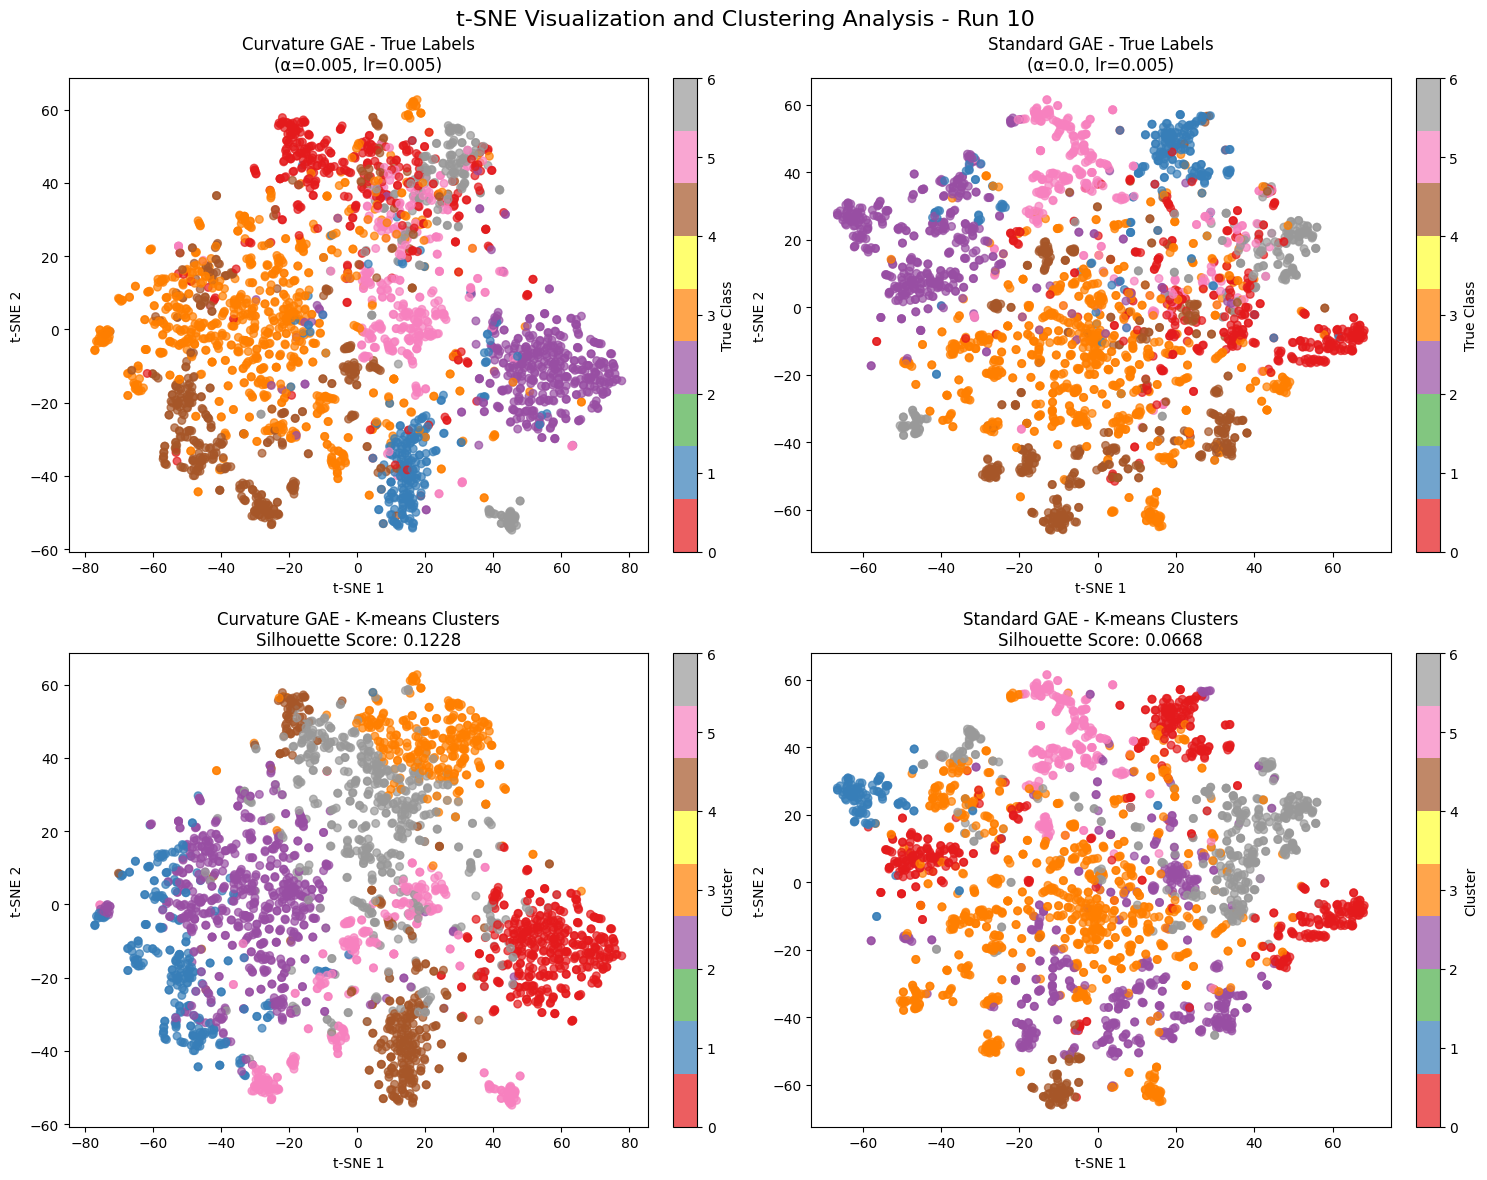


Additional Clustering Metrics:
Adjusted Rand Index:
  Curvature GAE: 0.3203
  Standard GAE: 0.2353
  ARI Improvement: +0.0850
Normalized Mutual Information:
  Curvature GAE: 0.3860
  Standard GAE: 0.3162
  NMI Improvement: +0.0698

t-SNE AND CLUSTERING SUMMARY
Silhouette Score Improvement: +0.0560
ARI Improvement: +0.0850
NMI Improvement: +0.0698


In [6]:
if __name__ == "__main__":
    # Set initial seed
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    print("Loading dataset...")
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    data = dataset[0]

    print(f"Dataset loaded: {data.x.size(0)} nodes, {data.edge_index.size(1)} edges")
    print(f"Feature dimension: {data.x.size(1)}, Number of classes: {dataset.num_classes}")

    # Store original data
    clean_data = data.clone()
    clean_data_features = data.x.clone()
    clean_data_edge_index = data.edge_index.clone()


    # Convert to NetworkX for initial analysis
    G_nx = to_networkx(data, to_undirected=True)
    if G_nx.number_of_edges() > 3000:
        # Sample edges for initial analysis
        edges_to_remove = list(G_nx.edges())[3000:]
        G_nx.remove_edges_from(edges_to_remove)

    print("--- Initial Geometric Analysis ---")
    initial_curvature = compute_forman_ricci(G_nx)
    target_mean, target_std = get_curvature_stats(initial_curvature, "Original Input Graph")
    
    # Choose what to run
    print(f"\n{'='*60}")
    print("CHOOSE EXPERIMENT TYPE:")
    print("1. Hyperparameter Search")
    print("2. Statistical Robustness Analysis")
    print("3. Both (Recommended)")
    print(f"{'='*60}")

    # For demo, let's run both. In practice, you might want to make this interactive
    run_hyperparameter_search = False
    run_robustness_analysis = True

    # 1. HYPERPARAMETER SEARCH
    if run_hyperparameter_search:
        print(f"\n{'='*60}")
        print("STEP 1: HYPERPARAMETER SEARCH")
        print(f"{'='*60}")

        # Define search space
        alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Curvature regularization strength
        lr_values = [0.0005, 0.001, 0.002, 0.005]        # Learning rates

        best_curv_config, best_std_config, results_df = hyperparameter_search(
            clean_data, (target_mean, target_std),
            alpha_values, lr_values,
            num_runs_per_config=5
        )
        # Show hyperparameter search results
        print(f"\n--- Hyperparameter Search Summary ---")
        print(results_df[['alpha_curv', 'lr', 'curv_mean_acc', 'std_mean_acc', 'mean_acc_improvement']].to_string(index=False))

    # Replace the robustness analysis section in your main execution block with this:
    if run_robustness_analysis:
        if not run_hyperparameter_search:
            # Use default configurations if hyperparameter search wasn't run
            best_curv_config = {'alpha_curv': 0.005, 'lr': 0.005}
            best_std_config = {'alpha_curv': 0, 'lr': 0.005}
        
        # Run robustness analysis with t-SNE visualization
        all_results, tsne_results = run_robustness_with_tsne_analysis(
            clean_data, (target_mean, target_std),
            best_curv_config, best_std_config,
            num_runs=10, noise_level=0.2
        )
        
        print(f"\n{'='*60}")
        print(f"t-SNE AND CLUSTERING SUMMARY")
        print(f"{'='*60}")
        print(f"Silhouette Score Improvement: {tsne_results['silhouette_curv'] - tsne_results['silhouette_std']:+.4f}")
        print(f"ARI Improvement: {tsne_results['ari_curv'] - tsne_results['ari_std']:+.4f}")
        print(f"NMI Improvement: {tsne_results['nmi_curv'] - tsne_results['nmi_std']:+.4f}")